<a href="https://colab.research.google.com/github/sthomas522/HF_agents/blob/main/experiments/GenAI_Final_Project_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Full bot

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install huggingface_hub[hf_xet]
#!pip install --upgrade tensorflow
!pip install --upgrade bitsandbytes
!pip install --upgrade langchain_openai langchain_core langgraph SPARQLWrapper
!pip install --upgrade duckduckgo-search wikipedia wikipedia-api
!pip install --upgrade opencv-python yt-dlp pytube
!pip install --upgrade langchain_huggingface langchain_community datasets gradio
!pip install --upgrade pillow spacy librosa
!pip install sentence-transformers
!pip install langchain faiss-cpu
!pip install pyppeteer
!pip install ipdb
!pip install beautifulsoup4
!pip install SpeechRecognition


Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
# Standard Library
import os
import re
import tempfile
import string
import glob
import shutil
import gc
import uuid
import signal
from datetime import datetime
from io import BytesIO
from contextlib import contextmanager
from typing import TypedDict, List, Optional, Dict, Any, Annotated, Literal, Union, Tuple, Set
import time

# Third-Party Packages
import cv2
import requests
import wikipedia
import spacy
import yt_dlp
import librosa
import ipdb
from PIL import Image
from bs4 import BeautifulSoup
from duckduckgo_search import DDGS
from sentence_transformers import SentenceTransformer
from transformers import BlipProcessor, BlipForQuestionAnswering, pipeline

# LangChain Ecosystem
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain_community.document_loaders import WikipediaLoader
from langchain_huggingface import HuggingFaceEndpoint
from langchain_community.retrievers import BM25Retriever
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, BaseMessage, SystemMessage, ToolMessage
from langchain_core.tools import BaseTool, StructuredTool, tool, render_text_description
from langchain_core.documents import Document

# LangGraph
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# PyTorch
import torch
from functools import partial
from transformers import pipeline

# Additional Utilities
from datetime import datetime

from urllib.parse import urljoin, urlparse
import logging
import nltk
from nltk.corpus import words
import string


In [4]:
nlp = spacy.load("en_core_web_sm")

# Ensure the word list is downloaded
nltk.download('words', quiet=True)
english_words = set(words.words())


In [5]:
# Define file extension sets for each category
PICTURE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}
AUDIO_EXTENSIONS = {'.mp3', '.wav', '.aac', '.flac', '.ogg', '.m4a', '.wma'}
CODE_EXTENSIONS = {'.py', '.js', '.java', '.cpp', '.c', '.cs', '.rb', '.go', '.php', '.html', '.css', '.ts'}
SPREADSHEET_EXTENSIONS = {
    '.xls', '.xlsx', '.xlsm', '.xlsb', '.xlt', '.xltx', '.xltm',
    '.ods', '.ots', '.csv', '.tsv', '.sxc', '.stc', '.dif', '.gsheet',
    '.numbers', '.numbers-tef', '.nmbtemplate', '.fods', '.123', '.wk1', '.wk2',
    '.wks', '.wku', '.wr1', '.gnumeric', '.gnm', '.xml', '.pmvx', '.pmdx',
    '.pmv', '.uos', '.txt'
}

def get_file_type(filename: str) -> str:
    if not filename or '.' not in filename or filename == '':
        return ''
    ext = filename.lower().rsplit('.', 1)[-1]
    dot_ext = f'.{ext}'
    if dot_ext in PICTURE_EXTENSIONS:
        return 'picture'
    elif dot_ext in AUDIO_EXTENSIONS:
        return 'audio'
    elif dot_ext in CODE_EXTENSIONS:
        return 'code'
    elif dot_ext in SPREADSHEET_EXTENSIONS:
        return 'spreadsheet'
    else:
        return 'unknown'

In [6]:
def write_bytes_to_temp_dir(file_bytes: bytes, file_name: str) -> str:
    """
    Writes bytes to a file in the system temporary directory using the provided file_name.
    Returns the full path to the saved file.
    The file will persist until manually deleted or the OS cleans the temp directory.
    """
    temp_dir = tempfile.gettempdir()
    file_path = os.path.join(temp_dir, file_name)
    with open(file_path, 'wb') as f:
        f.write(file_bytes)
    print(f"File written to: {file_path}")
    return file_path


In [7]:
DEFAULT_API_URL = "https://agents-course-unit4-scoring.hf.space"

api_url = DEFAULT_API_URL
questions_url = f"{api_url}/questions"
submit_url = f"{api_url}/submit"
files_url = f"{api_url}/files"

print(f"Fetching questions from: {questions_url}")
response = requests.get(questions_url, timeout=15)
response.raise_for_status()
hf_questions = response.json()

# Send GET request
response = requests.get(questions_url)

# Check if the request was successful
if response.status_code == 200:
    questions = response.json()
    print(questions)
else:
    print(f"Failed to retrieve questions. Status code: {response.status_code}")
    print(response.text)


questions = [item['question'] for item in response.json()]

# full details
hf_questions = response.json()

for item in hf_questions:
    file_name = item.get('file_name', '')
    if file_name == '':
        item['input_file'] = None
        item['file_type'] = None
        item['file_path'] = None
    else:
        # Call the API to retrieve the file; adjust params as needed
        task_id = item['task_id']
        api_response = requests.get(f"{files_url}/{task_id}")
        print(f"api_response = {api_response.status_code}")
        if api_response.status_code == 200:
            item['input_file'] = api_response.content  # Store file as bytes
            item['file_type'] = get_file_type(file_name)
            item['file_path'] = write_bytes_to_temp_dir(item['input_file'], file_name)
        else:
            item['input_file'] = None  # Or handle error as needed
            item['file_type'] = None
            item['file_path'] = None

Fetching questions from: https://agents-course-unit4-scoring.hf.space/questions
[{'task_id': '8e867cd7-cff9-4e6c-867a-ff5ddc2550be', 'question': 'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.', 'Level': '1', 'file_name': ''}, {'task_id': 'a1e91b78-d3d8-4675-bb8d-62741b4b68a6', 'question': 'In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?', 'Level': '1', 'file_name': ''}, {'task_id': '2d83110e-a098-4ebb-9987-066c06fa42d0', 'question': '.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI', 'Level': '1', 'file_name': ''}, {'task_id': 'cca530fc-4052-43b2-b130-b30968d8aa44', 'question': "Review the chess position provided in the image. It is black's turn. Provide the correct next move for black which guarantees a win. Please provide your response in algebraic notation.", 'Lev

In [8]:
hf_questions[3].keys()

dict_keys(['task_id', 'question', 'Level', 'file_name', 'input_file', 'file_type', 'file_path'])

In [9]:
hf_questions[2]['question']

'.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI'

In [10]:
import os
import glob
import shutil
import cv2
import yt_dlp
import torch
import hashlib
import json
import time
from PIL import Image, ImageFilter
from collections import Counter, defaultdict
from typing import Dict, Any, List, Tuple, Optional
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
import numpy as np
from transformers import BlipProcessor, BlipForQuestionAnswering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from langchain.tools import BaseTool
from pydantic import Field


class EnhancedYoutubeScreenshotQA(BaseTool):
    name: str = "enhanced_youtube_screenshot_qa"
    description: str = (
        "Downloads a YouTube video, intelligently extracts screenshots, "
        "and answers questions using advanced visual QA with semantic analysis. "
        "Use this tool for questions about the VIDEO or IMAGES in the video,"
        "Input should be a dict with keys: 'youtube_url', 'question', and optional parameters. "
        "Optional parameters: 'frame_interval_seconds' (default: 10), 'max_frames' (default: 50), "
        "'use_scene_detection' (default: True), 'resize_frames' (default: True), 'parallel_processing' (default: True). "
        "Example: {'youtube_url': 'https://youtube.com/watch?v=xyz', 'question': 'What animals are visible?'}"
    )

    # Define Pydantic fields for the attributes we need to set
    device: Any = Field(default=None, exclude=True)
    processor_vqa: Any = Field(default=None, exclude=True)
    model_vqa: Any = Field(default=None, exclude=True)

    class Config:
        # Allow arbitrary types (needed for torch.device, model objects)
        arbitrary_types_allowed = True
        # Allow extra fields to be set
        extra = "allow"

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Initialize directories
        cache_dir = '/tmp/youtube_qa_cache/'
        video_dir = '/tmp/video/'
        frames_dir = '/tmp/video_frames/'

        # Initialize model and device
        self._initialize_model()

        # Create directories
        for dir_path in [cache_dir, video_dir, frames_dir]:
            os.makedirs(dir_path, exist_ok=True)

    def _get_config(self, key: str, default_value=None, input_data: Dict[str, Any] = None):
        """Get configuration value with fallback to defaults"""
        defaults = {
            'frame_interval_seconds': 10,
            'max_frames': 50,
            'use_scene_detection': True,
            'resize_frames': True,
            'parallel_processing': True,
            'cache_enabled': True,
            'quality_threshold': 30.0,
            'semantic_similarity_threshold': 0.8
        }

        if input_data and key in input_data:
            return input_data[key]
        return defaults.get(key, default_value)

    def _initialize_model(self):
        """Initialize BLIP model for VQA with error handling"""
        try:
            #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.device = torch.device("cpu")
            print(f"Using device: {self.device}")

            self.processor_vqa = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
            self.model_vqa = BlipForQuestionAnswering.from_pretrained(
                "Salesforce/blip-vqa-base"
            ).to(self.device)

            print("BLIP VQA model loaded successfully")
        except Exception as e:
            print(f"Error initializing VQA model: {str(e)}")
            raise

    def _get_video_hash(self, url: str) -> str:
        """Generate hash for video URL for caching"""
        return hashlib.md5(url.encode()).hexdigest()

    def _get_cache_path(self, video_hash: str, cache_type: str) -> str:
        """Get cache file path"""
        cache_dir = '/tmp/youtube_qa_cache/'
        return os.path.join(cache_dir, f"{video_hash}_{cache_type}")

    def _load_from_cache(self, cache_path: str, cache_enabled: bool = True) -> Optional[Any]:
        """Load data from cache"""
        if not cache_enabled or not os.path.exists(cache_path):
            return None
        try:
            with open(cache_path, 'r') as f:
                return json.load(f)
        except Exception as e:
            print(f"Error loading cache: {str(e)}")
            return None

    def _save_to_cache(self, cache_path: str, data: Any, cache_enabled: bool = True):
        """Save data to cache"""
        if not cache_enabled:
            return
        try:
            with open(cache_path, 'w') as f:
                json.dump(data, f)
        except Exception as e:
            print(f"Error saving cache: {str(e)}")

    def download_youtube_video(self, url: str, video_hash: str, cache_enabled: bool = True) -> Optional[str]:
        """Enhanced YouTube video download with caching"""
        video_dir = '/tmp/video/'
        output_filename = f'{video_hash}.mp4'
        output_path = os.path.join(video_dir, output_filename)

        # Check cache
        if cache_enabled and os.path.exists(output_path):
            print(f"Using cached video: {output_path}")
            return output_path

        # Clean directory
        video_dir = '/tmp/video/'
        self._clean_directory(video_dir)

        try:
            ydl_opts = {
                'format': 'bestvideo[height<=720][ext=mp4]+bestaudio[ext=m4a]/best[height<=720][ext=mp4]/best',
                'outtmpl': output_path,
                'quiet': True,
                'merge_output_format': 'mp4',
                'postprocessors': [{
                    'key': 'FFmpegVideoConvertor',
                    'preferedformat': 'mp4',
                }]
            }

            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                ydl.download([url])

            if os.path.exists(output_path):
                print(f"Video downloaded successfully: {output_path}")
                return output_path
            else:
                print("Download completed but file not found")
                return None

        except Exception as e:
            print(f"Error downloading YouTube video: {str(e)}")
            return None

    def _clean_directory(self, directory: str):
        """Clean directory contents"""
        if os.path.exists(directory):
            for filename in os.listdir(directory):
                file_path = os.path.join(directory, filename)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                except Exception as e:
                    print(f'Failed to delete {file_path}. Reason: {e}')

    def _assess_frame_quality(self, frame: np.ndarray) -> float:
        """Assess frame quality using Laplacian variance (blur detection)"""
        try:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            return cv2.Laplacian(gray, cv2.CV_64F).var()
        except Exception:
            return 0.0

    def _detect_scene_changes(self, video_path: str, threshold: float = 30.0) -> List[int]:
        """Detect scene changes in video"""
        scene_frames = []
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                return []

            prev_frame = None
            frame_count = 0

            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                if prev_frame is not None:
                    # Calculate histogram difference
                    hist1 = cv2.calcHist([prev_frame], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
                    hist2 = cv2.calcHist([frame], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
                    diff = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)

                    if diff > threshold:
                        scene_frames.append(frame_count)

                prev_frame = frame.copy()
                frame_count += 1

            cap.release()
            return scene_frames

        except Exception as e:
            print(f"Error in scene detection: {str(e)}")
            return []

    def smart_extract_frames(self, video_path: str, video_hash: str, input_data: Dict[str, Any] = None) -> List[str]:
        """Intelligently extract frames with quality filtering and scene detection"""
        cache_enabled = self._get_config('cache_enabled', True, input_data)
        cache_path = self._get_cache_path(video_hash, "frames_info.json")
        cached_info = self._load_from_cache(cache_path, cache_enabled)

        if cached_info:
            # Verify cached frames still exist
            existing_frames = [f for f in cached_info['frame_paths'] if os.path.exists(f)]
            if len(existing_frames) == len(cached_info['frame_paths']):
                print(f"Using {len(existing_frames)} cached frames")
                return existing_frames

        # Clean frames directory
        frames_dir = '/tmp/video_frames/'
        self._clean_directory(frames_dir)

        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print("Error: Could not open video.")
                return []

            fps = cap.get(cv2.CAP_PROP_FPS)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_interval_seconds = self._get_config('frame_interval_seconds', 10, input_data)
            frame_interval = max(1, int(fps * frame_interval_seconds))

            print(f"Video info: {total_frames} frames, {fps:.2f} fps")

            # Get scene change frames if enabled
            scene_frames = set()
            use_scene_detection = self._get_config('use_scene_detection', True, input_data)
            if use_scene_detection:
                scene_frames = set(self._detect_scene_changes(video_path))
                print(f"Detected {len(scene_frames)} scene changes")

            extracted_frames = []
            frame_count = 0
            saved_count = 0
            max_frames = self._get_config('max_frames', 50, input_data)

            while True:
                ret, frame = cap.read()
                if not ret or saved_count >= max_frames:
                    break

                # Check if we should extract this frame
                should_extract = (
                    frame_count % frame_interval == 0 or
                    frame_count in scene_frames
                )

                if should_extract:
                    # Assess frame quality
                    quality = self._assess_frame_quality(frame)
                    quality_threshold = self._get_config('quality_threshold', 30.0, input_data)

                    if quality >= quality_threshold:
                        # Resize frame if enabled
                        resize_frames = self._get_config('resize_frames', True, input_data)
                        if resize_frames:
                            height, width = frame.shape[:2]
                            if width > 800:
                                scale = 800 / width
                                new_width = 800
                                new_height = int(height * scale)
                                frame = cv2.resize(frame, (new_width, new_height))

                        frame_filename = os.path.join(
                            frames_dir,
                            f"frame_{frame_count:06d}_q{quality:.1f}.jpg"
                        )

                        if cv2.imwrite(frame_filename, frame):
                            extracted_frames.append(frame_filename)
                            saved_count += 1
                            print(f"Extracted frame {saved_count}/{max_frames} "
                                  f"(quality: {quality:.1f})")

                frame_count += 1

            cap.release()

            # Cache frame information
            frame_info = {
                'frame_paths': extracted_frames,
                'extraction_time': time.time(),
                'total_frames_processed': frame_count,
                'frames_extracted': len(extracted_frames)
            }
            self._save_to_cache(cache_path, frame_info, cache_enabled)

            print(f"Successfully extracted {len(extracted_frames)} high-quality frames")
            return extracted_frames

        except Exception as e:
            print(f"Exception during frame extraction: {e}")
            return []

    def _answer_question_on_frame(self, frame_path: str, question: str) -> Tuple[str, float]:
        """Answer question on single frame with confidence scoring"""
        try:
            image = Image.open(frame_path).convert('RGB')
            inputs = self.processor_vqa(image, question, return_tensors="pt").to(self.device)

            with torch.no_grad():
                outputs = self.model_vqa.generate(**inputs, output_scores=True, return_dict_in_generate=True)

            answer = self.processor_vqa.decode(outputs.sequences[0], skip_special_tokens=True)

            # Calculate confidence (simplified - you might want to use actual model confidence)
            confidence = 1.0  # Placeholder - BLIP doesn't directly provide confidence

            return answer, confidence

        except Exception as e:
            print(f"Error processing frame {frame_path}: {str(e)}")
            return "Error processing this frame", 0.0

    def _process_frames_parallel(self, frame_files: List[str], question: str, input_data: Dict[str, Any] = None) -> List[Tuple[str, str, float]]:
        """Process frames in parallel"""
        results = []
        parallel_processing = self._get_config('parallel_processing', True, input_data)

        if parallel_processing:
            with ThreadPoolExecutor(max_workers=min(4, len(frame_files))) as executor:
                future_to_frame = {
                    executor.submit(self._answer_question_on_frame, frame_path, question): frame_path
                    for frame_path in frame_files
                }

                for future in as_completed(future_to_frame):
                    frame_path = future_to_frame[future]
                    try:
                        answer, confidence = future.result()
                        results.append((frame_path, answer, confidence))
                        print(f"Processed {os.path.basename(frame_path)}: {answer} (conf: {confidence:.2f})")
                    except Exception as e:
                        print(f"Error processing {frame_path}: {str(e)}")
                        results.append((frame_path, "Error", 0.0))
        else:
            for frame_path in frame_files:
                answer, confidence = self._answer_question_on_frame(frame_path, question)
                results.append((frame_path, answer, confidence))
                print(f"Processed {os.path.basename(frame_path)}: {answer} (conf: {confidence:.2f})")

        return results

    def _cluster_similar_answers(self, answers: List[str], input_data: Dict[str, Any] = None) -> Dict[str, List[str]]:
        """Cluster semantically similar answers"""
        if len(answers) <= 1:
            return {answers[0]: answers} if answers else {}

        try:
            # First try with standard TF-IDF settings
            vectorizer = TfidfVectorizer(
                stop_words='english',
                lowercase=True,
                min_df=1,  # Include words that appear in at least 1 document
                max_df=1.0  # Include words that appear in up to 100% of documents
            )
            tfidf_matrix = vectorizer.fit_transform(answers)

            # Check if we have any features after TF-IDF
            if tfidf_matrix.shape[1] == 0:
                raise ValueError("No features after TF-IDF processing")

            # Calculate cosine similarity
            similarity_matrix = cosine_similarity(tfidf_matrix)

            # Cluster similar answers
            clusters = defaultdict(list)
            used = set()
            semantic_similarity_threshold = self._get_config('semantic_similarity_threshold', 0.8, input_data)

            for i, answer in enumerate(answers):
                if i in used:
                    continue

                cluster_key = answer
                clusters[cluster_key].append(answer)
                used.add(i)

                # Find similar answers
                for j in range(i + 1, len(answers)):
                    if j not in used and similarity_matrix[i][j] >= semantic_similarity_threshold:
                        clusters[cluster_key].append(answers[j])
                        used.add(j)

            return dict(clusters)

        except (ValueError, Exception) as e:
            print(f"Error in semantic clustering: {str(e)}")

            # Fallback 1: Try without stop words filtering
            try:
                print("Attempting clustering without stop word filtering...")
                vectorizer_no_stop = TfidfVectorizer(
                    lowercase=True,
                    min_df=1,
                    token_pattern=r'\b\w+\b'  # Match any word
                )
                tfidf_matrix = vectorizer_no_stop.fit_transform(answers)

                if tfidf_matrix.shape[1] > 0:
                    similarity_matrix = cosine_similarity(tfidf_matrix)

                    clusters = defaultdict(list)
                    used = set()
                    semantic_similarity_threshold = self._get_config('semantic_similarity_threshold', 0.8, input_data)

                    for i, answer in enumerate(answers):
                        if i in used:
                            continue

                        cluster_key = answer
                        clusters[cluster_key].append(answer)
                        used.add(i)

                        for j in range(i + 1, len(answers)):
                            if j not in used and similarity_matrix[i][j] >= semantic_similarity_threshold:
                                clusters[cluster_key].append(answers[j])
                                used.add(j)

                    return dict(clusters)

            except Exception as e2:
                print(f"Fallback clustering also failed: {str(e2)}")

            # Fallback 2: Simple string-based clustering
            print("Using simple string-based clustering...")
            return self._simple_string_cluster(answers)

    def _simple_string_cluster(self, answers: List[str]) -> Dict[str, List[str]]:
        """Simple string-based clustering fallback"""
        clusters = defaultdict(list)

        # Normalize answers for comparison
        normalized_answers = {}
        for answer in answers:
            normalized = answer.lower().strip()
            normalized_answers[answer] = normalized

        used = set()

        for i, answer in enumerate(answers):
            if answer in used:
                continue

            cluster_key = answer
            clusters[cluster_key].append(answer)
            used.add(answer)

            # Find similar answers using simple string similarity
            for j, other_answer in enumerate(answers[i+1:], i+1):
                if other_answer in used:
                    continue

                # Check for exact match after normalization
                if normalized_answers[answer] == normalized_answers[other_answer]:
                    clusters[cluster_key].append(other_answer)
                    used.add(other_answer)
                # Alternatively, check if one string contains the other
                elif (normalized_answers[answer] in normalized_answers[other_answer] or
                      normalized_answers[other_answer] in normalized_answers[answer]):
                    clusters[cluster_key].append(other_answer)
                    used.add(other_answer)

        return dict(clusters)

    def _analyze_temporal_patterns(self, results: List[Tuple[str, str, float]]) -> Dict[str, Any]:
        """Analyze temporal patterns in answers"""
        try:
            # Sort by frame number
            def get_frame_number(frame_path):
                match = re.search(r'frame_(\d+)', os.path.basename(frame_path))
                return int(match.group(1)) if match else 0

            sorted_results = sorted(results, key=lambda x: get_frame_number(x[0]))

            # Analyze answer changes over time
            answers_timeline = [result[1] for result in sorted_results]
            changes = []

            for i in range(1, len(answers_timeline)):
                if answers_timeline[i] != answers_timeline[i-1]:
                    changes.append({
                        'frame_index': i,
                        'from_answer': answers_timeline[i-1],
                        'to_answer': answers_timeline[i]
                    })

            return {
                'total_changes': len(changes),
                'change_points': changes,
                'stability_ratio': 1 - (len(changes) / max(1, len(answers_timeline) - 1)),
                'answers_timeline': answers_timeline
            }

        except Exception as e:
            print(f"Error in temporal analysis: {str(e)}")
            return {'error': str(e)}

    def analyze_video_question(self, frame_files: List[str], question: str, input_data: Dict[str, Any] = None) -> Dict[str, Any]:
        """Comprehensive video question analysis"""
        if not frame_files:
            return {
                "final_answer": "No frames available for analysis.",
                "confidence": 0.0,
                "frame_count": 0,
                "error": "No valid frames found"
            }

        # Process all frames
        print(f"Processing {len(frame_files)} frames...")
        results = self._process_frames_parallel(frame_files, question, input_data)

        if not results:
            return {
                "final_answer": "Could not analyze any frames successfully.",
                "confidence": 0.0,
                "frame_count": 0,
                "error": "Frame processing failed"
            }

        # Extract answers and confidences
        answers = [result[1] for result in results if result[1] != "Error"]
        confidences = [result[2] for result in results if result[1] != "Error"]

        # Calculate statistical summary on numeric answers
        numeric_answers = []
        for answer in answers:
            try:
                # Try to convert answer to float
                numeric_value = float(answer)
                numeric_answers.append(numeric_value)
            except (ValueError, TypeError):
                # Skip non-numeric answers
                pass

        if numeric_answers:
            stats = {
                "minimum": float(np.min(numeric_answers)),
                "maximum": float(np.max(numeric_answers)),
                "range": float(np.max(numeric_answers) - np.min(numeric_answers)),
                "mean": float(np.mean(numeric_answers)),
                "median": float(np.median(numeric_answers)),
                "count": len(numeric_answers),
                "data_type": "answers"
            }
        elif confidences:
            # Fallback to confidence statistics if no numeric answers
            stats = {
                "minimum": float(np.min(confidences)),
                "maximum": float(np.max(confidences)),
                "range": float(np.max(confidences) - np.min(confidences)),
                "mean": float(np.mean(confidences)),
                "median": float(np.median(confidences)),
                "count": len(confidences),
                "data_type": "confidences"
            }
        else:
            stats = {
                "minimum": 0.0,
                "maximum": 0.0,
                "range": 0.0,
                "mean": 0.0,
                "median": 0.0,
                "count": 0,
                "data_type": "none",
                "note": "No numeric results available for statistical summary"
            }


        if not answers:
            return {
                "final_answer": "All frame processing failed.",
                "confidence": 0.0,
                "frame_count": len(frame_files),
                "error": "No successful frame analysis"
            }

        # Cluster similar answers
        answer_clusters = self._cluster_similar_answers(answers, input_data)

        # Find most common cluster
        largest_cluster = max(answer_clusters.items(), key=lambda x: len(x[1]))
        most_common_answer = largest_cluster[0]
        cluster_size = len(largest_cluster[1])

        # Calculate weighted confidence
        answer_counts = Counter(answers)
        total_answers = len(answers)
        frequency_confidence = answer_counts[most_common_answer] / total_answers
        avg_confidence = np.mean(confidences) if confidences else 0.0

        final_confidence = (frequency_confidence * 0.7) + (avg_confidence * 0.3)

        # Temporal analysis
        temporal_analysis = self._analyze_temporal_patterns(results)

        return {
            "final_answer": most_common_answer,
            "confidence": final_confidence,
            "frame_count": len(frame_files),
            "successful_analyses": len(answers),
            "answer_distribution": dict(answer_counts),
            "semantic_clusters": {k: len(v) for k, v in answer_clusters.items()},
            "temporal_analysis": temporal_analysis,
            "average_model_confidence": avg_confidence,
            "frequency_confidence": frequency_confidence,
            "statistical_summary": stats
        }

    #def _run(self, query: Dict[str, Any]) -> str:
    def _run(self, youtube_url, question) -> str:
        """Enhanced main execution method"""
        #ipdb.set_trace()

        #input_data = query
        #youtube_url = input_data.get("youtube_url")
        #question = input_data.get("question")
        input_data = {
            'youtube_url': youtube_url,
            'question': question
        }

        if not youtube_url or not question:
            return "Error: Input must include 'youtube_url' and 'question'."

        try:
            # Generate video hash for caching
            video_hash = self._get_video_hash(youtube_url)

            # Step 1: Download video
            print(f"Downloading YouTube video from {youtube_url}...")
            cache_enabled = self._get_config('cache_enabled', True, input_data)
            video_path = self.download_youtube_video(youtube_url, video_hash, cache_enabled)
            if not video_path or not os.path.exists(video_path):
                return "Error: Failed to download the YouTube video."

            # Step 2: Smart frame extraction
            print(f"Extracting frames with smart selection...")
            frame_files = self.smart_extract_frames(video_path, video_hash, input_data)
            if not frame_files:
                return "Error: Failed to extract frames from the video."

            # Step 3: Comprehensive analysis
            print(f"Analyzing {len(frame_files)} frames for question: '{question}'")
            analysis_result = self.analyze_video_question(frame_files, question, input_data)

            if analysis_result.get("error"):
                return f"Error: {analysis_result['error']}"

            # Format comprehensive result - Fixed the reference to stats
            result = f"""
📊 **ANALYSIS SUMMARY**:
• Confidence Score: {analysis_result['confidence']:.2%}
• Frames Analyzed: {analysis_result['successful_analyses']}/{analysis_result['frame_count']}
• Answer Consistency: {analysis_result['temporal_analysis'].get('stability_ratio', 0):.2%}

📈 **ANSWER DISTRIBUTION**:
{chr(10).join([f"• {answer}: {count} frames" for answer, count in analysis_result['answer_distribution'].items()])}

🔍 **SEMANTIC CLUSTERS**:
{chr(10).join([f"• '{cluster}': {count} similar answers" for cluster, count in analysis_result['semantic_clusters'].items()])}

⏱️ **TEMPORAL ANALYSIS**:
• Answer Changes: {analysis_result['temporal_analysis'].get('total_changes', 0)}
• Stability: {analysis_result['temporal_analysis'].get('stability_ratio', 0):.2%}

📊 **STATISTICAL SUMMARY**:
• Minimum: {analysis_result['statistical_summary']['minimum']:.2f}
• Maximum: {analysis_result['statistical_summary']['maximum']:.2f}
• Mean: {analysis_result['statistical_summary']['mean']:.2f}
• Median: {analysis_result['statistical_summary']['median']:.2f}
• Range: {analysis_result['statistical_summary']['range']:.2f}

🎯 **CONFIDENCE BREAKDOWN**:
• Frequency-based: {analysis_result['frequency_confidence']:.2%}
• Model-based: {analysis_result['average_model_confidence']:.2%}
• Combined: {analysis_result['confidence']:.2%}
            """.strip()

            return result

        except Exception as e:
            return f"Error during video analysis: {str(e)}"


# Initialize the enhanced tool
def create_enhanced_youtube_qa_tool(**kwargs):
    """Factory function to create the enhanced tool with custom parameters"""
    return EnhancedYoutubeScreenshotQA(**kwargs)

In [11]:
#tool = EnhancedYoutubeScreenshotQA()
#result = tool._run(
#     "https://www.youtube.com/watch?v=L1vXCYZAYYM",
#    "what is the highest number of bird species to be on camera simultaneously??"
#)

In [12]:
#print(result)

In [13]:
import os
import glob
import shutil
import hashlib
import json
import time
import wave
import subprocess
from typing import Dict, Any, List, Optional
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
import numpy as np
import yt_dlp
import speech_recognition as sr
from pydub import AudioSegment
from pydub.silence import split_on_silence
from langchain.tools import BaseTool
from pydantic import Field
import nltk
from nltk.corpus import words
import string


class YouTubeTranscriptExtractor(BaseTool):
    name: str = "youtube_transcript_extractor"
    description: str = (
        "Downloads a YouTube video and extracts the complete audio transcript using speech recognition. "
        "Use this tool when you need the AUDIO or DIALOGUE or sound from a YouTube video,"
        "Input should be a dict with keys: 'youtube_url' and optional parameters. "
        "Optional parameters: 'language' (default: 'en-US'), 'chunk_length_ms' (default: 30000), "
        "'silence_thresh' (default: -40), 'use_enhanced_model' (default: True), 'audio_quality' (default: 'best'). "
        "Example: {'youtube_url': 'https://youtube.com/watch?v=xyz', 'language': 'en-US'}"
    )

    # Define Pydantic fields for the attributes we need to set
    recognizer: Any = Field(default=None, exclude=True)

    class Config:
        # Allow arbitrary types
        arbitrary_types_allowed = True
        # Allow extra fields to be set
        extra = "allow"

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Initialize directories
        cache_dir = '/tmp/youtube_transcript_cache/'
        audio_dir = '/tmp/audio/'
        chunks_dir = '/tmp/audio_chunks/'

        # Initialize speech recognizer
        self.recognizer = sr.Recognizer()

        # Create directories
        for dir_path in [cache_dir, audio_dir, chunks_dir]:
            os.makedirs(dir_path, exist_ok=True)

    def _get_config(self, key: str, default_value=None, input_data: Dict[str, Any] = None):
        """Get configuration value with fallback to defaults"""
        defaults = {
            'language': 'en-US',
            'chunk_length_ms': 30000,  # 30 seconds
            'silence_thresh': -40,     # dB
            'use_enhanced_model': True,
            'audio_quality': 'best',
            'cache_enabled': True,
            'parallel_processing': True,
            'overlap_ms': 1000,        # 1 second overlap between chunks
            'min_silence_len': 500,    # minimum silence length to split on
            'energy_threshold': 4000,  # recognizer energy threshold
            'pause_threshold': 0.8     # recognizer pause threshold
        }

        if input_data and key in input_data:
            return input_data[key]
        return defaults.get(key, default_value)

    def _get_video_hash(self, url: str) -> str:
        """Generate hash for video URL for caching"""
        return hashlib.md5(url.encode()).hexdigest()

    def _get_cache_path(self, video_hash: str, cache_type: str) -> str:
        """Get cache file path"""
        cache_dir = '/tmp/youtube_transcript_cache/'
        return os.path.join(cache_dir, f"{video_hash}_{cache_type}")

    def _load_from_cache(self, cache_path: str, cache_enabled: bool = True) -> Optional[Any]:
        """Load data from cache"""
        if not cache_enabled or not os.path.exists(cache_path):
            return None
        try:
            with open(cache_path, 'r', encoding='utf-8') as f:
                return json.load(f)
        except Exception as e:
            print(f"Error loading cache: {str(e)}")
            return None

    def _save_to_cache(self, cache_path: str, data: Any, cache_enabled: bool = True):
        """Save data to cache"""
        if not cache_enabled:
            return
        try:
            with open(cache_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=2)
        except Exception as e:
            print(f"Error saving cache: {str(e)}")

    def download_youtube_audio(self, url: str, video_hash: str, input_data: Dict[str, Any] = None) -> Optional[str]:
        """Download YouTube video as audio file"""
        audio_dir = '/tmp/audio/'
        audio_quality = self._get_config('audio_quality', 'best', input_data)
        output_filename = f'{video_hash}.wav'
        output_path = os.path.join(audio_dir, output_filename)

        # Check cache
        cache_enabled = self._get_config('cache_enabled', True, input_data)
        if cache_enabled and os.path.exists(output_path):
            print(f"Using cached audio: {output_path}")
            return output_path

        # Clean directory
        self._clean_directory(audio_dir)

        try:
            # First download as mp4/webm
            temp_video_path = os.path.join(audio_dir, f'{video_hash}_temp.%(ext)s')

            ydl_opts = {
                'format': 'bestaudio/best' if audio_quality == 'best' else 'worstaudio/worst',
                'outtmpl': temp_video_path,
                'quiet': True,
                'extractaudio': True,
                'audioformat': 'wav',
                'audioquality': '192K' if audio_quality == 'best' else '64K',
            }

            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                ydl.download([url])

            # Find the downloaded file
            temp_files = glob.glob(os.path.join(audio_dir, f'{video_hash}_temp.*'))
            if not temp_files:
                print("No temporary audio file found")
                return None

            temp_file = temp_files[0]

            # Convert to WAV if not already
            if not temp_file.endswith('.wav'):
                try:
                    audio = AudioSegment.from_file(temp_file)
                    audio.export(output_path, format="wav")
                    os.remove(temp_file)  # Clean up temp file
                except Exception as e:
                    print(f"Error converting audio: {str(e)}")
                    # Try to rename if it's already the right format
                    if os.path.exists(temp_file):
                        os.rename(temp_file, output_path)
            else:
                os.rename(temp_file, output_path)

            if os.path.exists(output_path):
                print(f"Audio extracted successfully: {output_path}")
                return output_path
            else:
                print("Audio extraction completed but file not found")
                return None

        except Exception as e:
            print(f"Error downloading YouTube audio: {str(e)}")
            return None

    def _clean_directory(self, directory: str):
        """Clean directory contents"""
        if os.path.exists(directory):
            for filename in os.listdir(directory):
                file_path = os.path.join(directory, filename)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                except Exception as e:
                    print(f'Failed to delete {file_path}. Reason: {e}')

    def _split_audio_intelligent(self, audio_path: str, input_data: Dict[str, Any] = None) -> List[str]:
        """Split audio into chunks intelligently based on silence"""
        chunks_dir = '/tmp/audio_chunks/'
        self._clean_directory(chunks_dir)

        try:
            # Load audio
            audio = AudioSegment.from_wav(audio_path)

            # Get configuration
            chunk_length_ms = self._get_config('chunk_length_ms', 30000, input_data)
            silence_thresh = self._get_config('silence_thresh', -40, input_data)
            min_silence_len = self._get_config('min_silence_len', 500, input_data)
            overlap_ms = self._get_config('overlap_ms', 1000, input_data)

            # First try to split on silence
            chunks = split_on_silence(
                audio,
                min_silence_len=min_silence_len,
                silence_thresh=silence_thresh,
                keep_silence=True
            )

            # If no silence-based splits or chunks too large, split by time
            if not chunks or any(len(chunk) > chunk_length_ms * 2 for chunk in chunks):
                print("Using time-based splitting...")
                chunks = []
                for i in range(0, len(audio), chunk_length_ms - overlap_ms):
                    chunk = audio[i:i + chunk_length_ms]
                    if len(chunk) > 1000:  # Only add chunks longer than 1 second
                        chunks.append(chunk)

            # Save chunks
            chunk_files = []
            for i, chunk in enumerate(chunks):
                if len(chunk) < 1000:  # Skip very short chunks
                    continue

                chunk_filename = os.path.join(chunks_dir, f"chunk_{i:04d}.wav")
                chunk.export(chunk_filename, format="wav")
                chunk_files.append(chunk_filename)

            print(f"Split audio into {len(chunk_files)} chunks")
            return chunk_files

        except Exception as e:
            print(f"Error splitting audio: {str(e)}")
            # Fallback: return original file
            return [audio_path]

    def _transcribe_audio_chunk(self, chunk_path: str, input_data: Dict[str, Any] = None) -> Dict[str, Any]:
        """Transcribe a single audio chunk"""
        try:
            language = self._get_config('language', 'en-US', input_data)

            # Configure recognizer
            self.recognizer.energy_threshold = self._get_config('energy_threshold', 4000, input_data)
            self.recognizer.pause_threshold = self._get_config('pause_threshold', 0.8, input_data)

            with sr.AudioFile(chunk_path) as source:
                # Adjust for ambient noise
                self.recognizer.adjust_for_ambient_noise(source, duration=0.5)
                audio_data = self.recognizer.record(source)

            # Try Google Speech Recognition first (most accurate)
            try:
                text = self.recognizer.recognize_google(audio_data, language=language)
                return {
                    'text': text,
                    'confidence': 1.0,  # Google doesn't provide confidence
                    'method': 'google',
                    'chunk': os.path.basename(chunk_path)
                }
            except sr.UnknownValueError:
                # Try alternative recognition methods
                try:
                    # Try with alternative language detection
                    text = self.recognizer.recognize_google(audio_data)
                    return {
                        'text': text,
                        'confidence': 0.8,  # Lower confidence for language mismatch
                        'method': 'google_auto',
                        'chunk': os.path.basename(chunk_path)
                    }
                except sr.UnknownValueError:
                    return {
                        'text': '[INAUDIBLE]',
                        'confidence': 0.0,
                        'method': 'failed',
                        'chunk': os.path.basename(chunk_path)
                    }
            except sr.RequestError as e:
                print(f"Google Speech Recognition error: {e}")
                return {
                    'text': '[RECOGNITION_ERROR]',
                    'confidence': 0.0,
                    'method': 'error',
                    'chunk': os.path.basename(chunk_path),
                    'error': str(e)
                }

        except Exception as e:
            print(f"Error transcribing chunk {chunk_path}: {str(e)}")
            return {
                'text': '[ERROR]',
                'confidence': 0.0,
                'method': 'error',
                'chunk': os.path.basename(chunk_path),
                'error': str(e)
            }

    def _transcribe_chunks_parallel(self, chunk_files: List[str], input_data: Dict[str, Any] = None) -> List[Dict[str, Any]]:
        """Transcribe audio chunks in parallel"""
        results = []
        parallel_processing = self._get_config('parallel_processing', True, input_data)

        if parallel_processing:
            # Use fewer workers for speech recognition to avoid API limits
            max_workers = min(3, len(chunk_files))
            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                future_to_chunk = {
                    executor.submit(self._transcribe_audio_chunk, chunk_path, input_data): chunk_path
                    for chunk_path in chunk_files
                }

                for future in as_completed(future_to_chunk):
                    chunk_path = future_to_chunk[future]
                    try:
                        result = future.result()
                        results.append(result)
                        print(f"Transcribed {result['chunk']}: {result['text'][:50]}..." if len(result['text']) > 50 else f"Transcribed {result['chunk']}: {result['text']}")
                    except Exception as e:
                        print(f"Error processing {chunk_path}: {str(e)}")
                        results.append({
                            'text': '[PROCESSING_ERROR]',
                            'confidence': 0.0,
                            'method': 'error',
                            'chunk': os.path.basename(chunk_path),
                            'error': str(e)
                        })
        else:
            for chunk_path in chunk_files:
                result = self._transcribe_audio_chunk(chunk_path, input_data)
                results.append(result)
                print(f"Transcribed {result['chunk']}: {result['text'][:50]}..." if len(result['text']) > 50 else f"Transcribed {result['chunk']}: {result['text']}")

        # Sort results by chunk name to maintain order
        results.sort(key=lambda x: x['chunk'])
        return results

    def _post_process_transcript(self, transcript_results: List[Dict[str, Any]]) -> Dict[str, Any]:
        """Post-process and analyze transcript results"""
        # Combine all text
        full_text = []
        successful_chunks = 0
        total_confidence = 0.0
        method_counts = {}

        for result in transcript_results:
            if result['text'] not in ['[INAUDIBLE]', '[RECOGNITION_ERROR]', '[ERROR]', '[PROCESSING_ERROR]']:
                full_text.append(result['text'])
                successful_chunks += 1
                total_confidence += result['confidence']

            method = result['method']
            method_counts[method] = method_counts.get(method, 0) + 1

        combined_text = ' '.join(full_text)

        # Calculate statistics
        word_count = len(combined_text.split()) if combined_text else 0
        char_count = len(combined_text)
        avg_confidence = total_confidence / max(1, successful_chunks)
        success_rate = successful_chunks / len(transcript_results) if transcript_results else 0

        # Estimate speaking duration (rough approximation: 150 words per minute)
        estimated_duration_minutes = word_count / 150 if word_count > 0 else 0

        return {
            'full_transcript': combined_text,
            'word_count': word_count,
            'character_count': char_count,
            'chunk_count': len(transcript_results),
            'successful_chunks': successful_chunks,
            'success_rate': success_rate,
            'average_confidence': avg_confidence,
            'method_distribution': method_counts,
            'estimated_duration_minutes': estimated_duration_minutes,
            'detailed_results': transcript_results
        }

    def extract_transcript(self, audio_path: str, video_hash: str, input_data: Dict[str, Any] = None) -> Dict[str, Any]:
        """Extract complete transcript from audio file"""
        cache_enabled = self._get_config('cache_enabled', True, input_data)
        cache_path = self._get_cache_path(video_hash, "transcript.json")

        # Check cache
        cached_transcript = self._load_from_cache(cache_path, cache_enabled)
        if cached_transcript:
            print("Using cached transcript")
            return cached_transcript

        try:
            # Step 1: Split audio into manageable chunks
            print("Splitting audio into chunks...")
            chunk_files = self._split_audio_intelligent(audio_path, input_data)

            if not chunk_files:
                return {
                    'error': 'Failed to split audio into chunks',
                    'full_transcript': '',
                    'success_rate': 0.0
                }

            # Step 2: Transcribe all chunks
            print(f"Transcribing {len(chunk_files)} audio chunks...")
            transcript_results = self._transcribe_chunks_parallel(chunk_files, input_data)

            # Step 3: Post-process and combine results
            print("Post-processing transcript...")
            final_result = self._post_process_transcript(transcript_results)

            # Add timestamp
            final_result['extraction_timestamp'] = time.time()
            final_result['extraction_date'] = time.strftime('%Y-%m-%d %H:%M:%S')

            # Cache results
            self._save_to_cache(cache_path, final_result, cache_enabled)

            return final_result

        except Exception as e:
            print(f"Error during transcript extraction: {str(e)}")
            return {
                'error': str(e),
                'full_transcript': '',
                'success_rate': 0.0
            }

    def _run(self, youtube_url: str, **kwargs) -> str:
        """Main execution method"""
        input_data = {
            'youtube_url': youtube_url,
            **kwargs
        }

        if not youtube_url:
            return "Error: youtube_url is required."

        try:
            # Generate video hash for caching
            video_hash = self._get_video_hash(youtube_url)

            # Step 1: Download audio
            print(f"Downloading YouTube audio from {youtube_url}...")
            audio_path = self.download_youtube_audio(youtube_url, video_hash, input_data)
            if not audio_path or not os.path.exists(audio_path):
                return "Error: Failed to download the YouTube audio."

            # Step 2: Extract transcript
            print("Extracting audio transcript...")
            transcript_result = self.extract_transcript(audio_path, video_hash, input_data)

            if transcript_result.get("error"):
                return f"Error: {transcript_result['error']}"

            # Format comprehensive result
            result = f"""
🎵 **TRANSCRIPT EXTRACTION SUMMARY**:
• Success Rate: {transcript_result['success_rate']:.1%}
• Chunks Processed: {transcript_result['successful_chunks']}/{transcript_result['chunk_count']}
• Average Confidence: {transcript_result['average_confidence']:.1%}

📊 **CONTENT STATISTICS**:
• Word Count: {transcript_result['word_count']:,}
• Character Count: {transcript_result['character_count']:,}
• Estimated Duration: {transcript_result['estimated_duration_minutes']:.1f} minutes

🔧 **PROCESSING METHODS**:
{chr(10).join([f"• {method}: {count} chunks" for method, count in transcript_result['method_distribution'].items()])}

📝 **FULL TRANSCRIPT**:
{transcript_result['full_transcript']}

⚠️ **NOTE**: Transcript accuracy depends on audio quality, speech clarity, and background noise levels.
            """.strip()

            return result

        except Exception as e:
            return f"Error during transcript extraction: {str(e)}"


# Factory function to create the tool
def create_youtube_transcript_tool(**kwargs):
    """Factory function to create the transcript extraction tool with custom parameters"""
    return YouTubeTranscriptExtractor(**kwargs)

In [14]:
print(hf_questions[1])

{'task_id': 'a1e91b78-d3d8-4675-bb8d-62741b4b68a6', 'question': 'In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?', 'Level': '1', 'file_name': '', 'input_file': None, 'file_type': None, 'file_path': None}


In [15]:
import requests
import time
import re
import logging
from typing import List, Dict, Optional, Any
from bs4 import BeautifulSoup
from duckduckgo_search import DDGS
from langchain_core.tools import BaseTool

logger = logging.getLogger(__name__)

class EnhancedDuckDuckGoSearchTool(BaseTool):
    name: str = "enhanced_search"
    description: str = (
        "Performs a DuckDuckGo web search and retrieves actual content from the top web results. "
        "Input should be a search query string. "
        "Returns search results with extracted content from web pages, making it much more useful for answering questions. "
        "Use this tool when you need up-to-date information, details about current events, or when other tools do not provide sufficient or recent answers. "
        "Ideal for topics that require the latest news, recent developments, or information not covered in static sources."
    )
    max_results: int = 3
    max_chars_per_page: int = 3000
    session: Any = None  # Now it's optional and defaults to None


    # Use model_post_init for initialization logic in Pydantic v2+
    def model_post_init(self, __context: Any) -> None:
        super().model_post_init(__context)
        # Initialize HTTP session here
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
        })

    def _search_duckduckgo(self, query: str) -> List[Dict]:
        """Perform DuckDuckGo search and return results."""
        try:
            with DDGS() as ddgs:
                results = list(ddgs.text(query, max_results=self.max_results))
                return results
        except Exception as e:
            logger.error(f"DuckDuckGo search failed: {e}")
            return []

    def _extract_content_from_url(self, url: str, timeout: int = 10) -> Optional[str]:
        """Extract clean text content from a web page."""
        try:
            # Skip certain file types
            if any(url.lower().endswith(ext) for ext in ['.pdf', '.doc', '.docx', '.xls', '.xlsx', '.ppt', '.pptx']):
                return "Content type not supported for extraction"

            response = self.session.get(url, timeout=timeout, allow_redirects=True)
            response.raise_for_status()

            # Check content type
            content_type = response.headers.get('content-type', '').lower()
            if 'text/html' not in content_type:
                return "Non-HTML content detected"

            soup = BeautifulSoup(response.content, 'html.parser')

            # Remove script and style elements
            for script in soup(["script", "style", "nav", "header", "footer", "aside", "form"]):
                script.decompose()

            # Try to find main content areas
            main_content = None
            for selector in ['main', 'article', '.content', '#content', '.post', '.entry']:
                main_content = soup.select_one(selector)
                if main_content:
                    break

            if not main_content:
                main_content = soup.find('body') or soup

            # Extract text
            text = main_content.get_text(separator='\n', strip=True)

            # Clean up the text
            lines = [line.strip() for line in text.split('\n') if line.strip()]
            text = '\n'.join(lines)

            # Remove excessive whitespace
            text = re.sub(r'\n{3,}', '\n\n', text)
            text = re.sub(r' {2,}', ' ', text)

            # Truncate if too long
            if len(text) > self.max_chars_per_page:
                text = text[:self.max_chars_per_page] + "\n[Content truncated...]"

            return text

        except requests.exceptions.Timeout:
            return "Page loading timed out"
        except requests.exceptions.RequestException as e:
            return f"Failed to retrieve page: {str(e)}"
        except Exception as e:
            logger.error(f"Content extraction failed for {url}: {e}")
            return "Failed to extract content from page"

    def _format_search_result(self, result: Dict, content: str) -> str:
        """Format a single search result with its content."""
        title = result.get('title', 'No title')
        url = result.get('href', 'No URL')
        snippet = result.get('body', 'No snippet')

        formatted = f"""
🔍 **{title}**
URL: {url}
Snippet: {snippet}

📄 **Page Content:**
{content}
---
"""
        return formatted

    def run(self, query: str) -> str:

        """Execute the enhanced search."""
        if not query or not query.strip():
            return "Please provide a search query."

        query = query.strip()
        logger.info(f"Searching for: {query}")

        # Perform DuckDuckGo search
        search_results = self._search_duckduckgo(query)

        if not search_results:
            return f"No search results found for query: {query}"

        # Process each result and extract content
        enhanced_results = []
        processed_count = 0

        for i, result in enumerate(search_results[:self.max_results]):
            url = result.get('href', '')
            if not url:
                continue

            logger.info(f"Processing result {i+1}: {url}")

            # Extract content from the page
            content = self._extract_content_from_url(url)

            if content and len(content.strip()) > 50:  # Only include results with substantial content
                formatted_result = self._format_search_result(result, content)
                enhanced_results.append(formatted_result)
                processed_count += 1

            # Small delay to be respectful to servers
            time.sleep(0.5)

        if not enhanced_results:
            return f"Search completed but no content could be extracted from the pages for query: {query}"

        # Compile final response
        response = f"""🔍 **Enhanced Search Results for: "{query}"**
Found {len(search_results)} results, successfully processed {processed_count} pages with content.

{''.join(enhanced_results)}

💡 **Summary:** Retrieved and processed content from {processed_count} web pages to provide comprehensive information about your search query.
"""

        # Ensure the response isn't too long
        if len(response) > 8000:
            response = response[:8000] + "\n[Response truncated to prevent memory issues]"

        return response

    def _run(self, query: str) -> str:
        """Required by BaseTool interface."""
        return self.run(query)

In [16]:

# Test the enhanced search tool
search_tool = EnhancedDuckDuckGoSearchTool(max_results=2, max_chars_per_page=2000)
result = search_tool.run("2025 NBA Eastern Conference Finals teams")

In [17]:
len(result)

5076

In [18]:
def extract_final_answer(text: str) -> str:
  """
  Returns the substring starting from the last occurrence of 'FINAL ANSWER:' (case-insensitive)
  to the end of the string, with any trailing punctuation removed.
  If not found, returns an empty string.
  """
  marker = "FINAL ANSWER:"
  idx = text.lower().rfind(marker.lower())
  if idx == -1:
    return ""
  result = text[idx:].strip()
  # Remove trailing punctuation
  return result.rstrip(string.punctuation + " ")

In [19]:

def extract_final_and_thought(text: str) -> dict:
    """
    Extracts two objects from the text: 'Final Answer' and 'Thought'.
    Returns a dictionary with keys 'Final Answer' and 'Thought'.
    If not found, the values will be empty strings.
    """
    final_answer_marker = "Final Answer:"
    thought_marker = "Thought:"

    # Find the start indices of the markers
    final_answer_idx = text.lower().find(final_answer_marker.lower())
    thought_idx = text.lower().find(thought_marker.lower())

    final_answer = ""
    thought = ""

    if final_answer_idx != -1:
        # Extract from final_answer_marker to the end of line or next marker
        start = final_answer_idx + len(final_answer_marker)
        # Find the end of line or next marker
        end = len(text)
        if thought_idx != -1 and thought_idx > final_answer_idx:
            end = thought_idx
        final_answer = text[start:end].strip().rstrip(string.punctuation + " ")

    if thought_idx != -1:
        # Extract from thought_marker to the end of the string
        start = thought_idx + len(thought_marker)
        thought = text[start:].strip()

    return {"Final Answer": final_answer, "Thought": thought}

In [20]:
import re
import gc
import uuid # For generating unique tool call IDs
from datetime import datetime
from langchain_core.tools import BaseTool, StructuredTool, tool
from typing import TypedDict, Annotated, List, Optional, Dict, Any, Literal, Union, Tuple, Set
import ast
import ipdb

from bs4 import BeautifulSoup

import torch
import wikipedia # For WikipediaLoader
import requests # For WikipediaLoader
from transformers import pipeline
import signal
from contextlib import contextmanager
import torch
import re
import uuid
from functools import partial

#from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import BaseTool, StructuredTool, tool, render_text_description
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_huggingface import HuggingFacePipeline
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings # Uses sentence-transformers


from langgraph.graph import StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode

# --- Model Configuration ---
def create_llm_pipeline():
    #model_id = "meta-llama/Llama-2-13b-chat-hf"
    #model_id = "meta-llama/Llama-3.3-70B-Instruct"
    #model_id = "mistralai/Mistral-Small-24B-Base-2501"
    model_id = "mistralai/Mistral-7B-Instruct-v0.3"
    #model_id = "Qwen/Qwen2-7B-Instruct"
    return pipeline(
        "text-generation",
        model=model_id,
        device_map="auto",
        torch_dtype=torch.float16,
        max_new_tokens=1024,
        temperature=0.1
    )


#model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
#model_id = "mistralai/Mixtral-8x7B-Instruct-v0.1"
# model_id = "meta-llama/Llama-2-13b-chat-hf"
#model_id = "Qwen/Qwen2.5-Coder-32B-Instruct" # As specified by user

nlp = None # Set to None if not using spaCy, so the regex fallback is used in extract_entities

# --- Agent State Definition ---
class AgentState(TypedDict):
    messages: Annotated[List[AnyMessage], lambda x, y: x + y]
    done: bool = False  # Default value of False
    question: str
    task_id: str
    input_file: Optional[bytes]
    file_type: Optional[str]
    context: List[Document]  # Using LangChain's Document class
    file_path: Optional[str]
    youtube_url: Optional[str]
    answer: Optional[str]
    frame_answers: Optional[list]


def fetch_page_with_tables(page_title):
    """
    Fetches Wikipedia page content and extracts all tables as readable text.
    Returns a tuple: (main_text, [table_texts])
    """
    # Fetch the page object
    page = wikipedia.page(page_title)
    main_text = page.content

    # Get the HTML for table extraction
    html = page.html()
    soup = BeautifulSoup(html, 'html.parser')
    tables = soup.find_all('table')

    table_texts = []
    for table in tables:
        rows = table.find_all('tr')
        table_lines = []
        for row in rows:
            cells = row.find_all(['th', 'td'])
            cell_texts = [cell.get_text(strip=True) for cell in cells]
            if cell_texts:
                # Format as Markdown table row
                table_lines.append(" | ".join(cell_texts))
        if table_lines:
            table_text = "\n".join(table_lines)
            table_texts.append(table_text)

    return main_text, table_texts

class WikipediaSearchToolWithFAISS(BaseTool):
    name: str = "wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval"
    description: str = (
        "Fetches content from multiple Wikipedia pages based on intelligent NLP query processing "
        "of various search candidates, with strong prioritization of query entities. It then performs "
        "entity-focused semantic search across all fetched content to find the most relevant information, "
        "with improved retrieval for lists like discographies. Uses spaCy for named entity "
        "recognition and query enhancement. Input should be a search query or topic. "
        "Note: Uses the current live version of Wikipedia."
    )
    embedding_model_name: str = "all-MiniLM-L6-v2"
    chunk_size: int = 4000
    chunk_overlap: int = 250 # Maintained moderate overlap
    top_k_results: int = 3
    spacy_model: str = "en_core_web_sm"
    # Increased multiplier to fetch more candidates per semantic query variant
    semantic_search_candidate_multiplier: int = 1 # Was 2, increased to 3, consider 4 if still problematic

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        try:
            self._nlp = spacy.load(self.spacy_model)
            print(f"Loaded spaCy model: {self.spacy_model}")
            self._embedding_model = HuggingFaceEmbeddings(model_name=self.embedding_model_name)
            # Refined separators for better handling of Wikipedia lists and sections
            self._text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=self.chunk_size,
                chunk_overlap=self.chunk_overlap,
                separators=[
                    "\n\n== ", "\n\n=== ", "\n\n==== ",  # Section headers (keep with following content)
                    "\n\n\n", "\n\n",  # Multiple newlines (paragraph breaks)
                    "\n* ", "\n- ", "\n# ", # List items
                    "\n", ". ", "! ", "? ", # Sentence breaks after newline, common punctuation
                    " ", "" # Word and character level
                ]
            )
        except OSError as e:
            print(f"Error loading spaCy model '{self.spacy_model}': {e}")
            print("Try running: python -m spacy download en_core_web_sm")
            self._nlp = None
            self._embedding_model = None
            self._text_splitter = None
        except Exception as e:
            print(f"Error initializing WikipediaSearchToolWithFAISS components: {e}")
            self._nlp = None
            self._embedding_model = None
            self._text_splitter = None

    def _extract_entities_and_keywords(self, query: str) -> Tuple[List[str], List[str], str]:
        if not self._nlp:
            return [], [], query
        doc = self._nlp(query)
        main_entities = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE", "EVENT", "WORK_OF_ART"]]
        keywords = [token.lemma_.lower() for token in doc if token.pos_ in ["NOUN", "PROPN", "ADJ"] and not token.is_stop and not token.is_punct and len(token.text) > 2]
        main_entities = list(dict.fromkeys(main_entities))
        keywords = list(dict.fromkeys(keywords))
        processed_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.text.strip()]
        processed_query = " ".join(processed_tokens)
        return main_entities, keywords, processed_query

    def _generate_search_candidates(self, query: str, main_entities: List[str], keywords: List[str], processed_query: str) -> List[str]:
        candidates_set = set()
        entity_prefix = main_entities[0] if main_entities else None

        for me in main_entities:
            candidates_set.add(me)
        candidates_set.add(query)
        if processed_query and processed_query != query:
            candidates_set.add(processed_query)

        if entity_prefix and keywords:
            first_entity_lower = entity_prefix.lower()
            for kw in keywords[:3]:
                if kw not in first_entity_lower and len(kw) > 2:
                    candidates_set.add(f"{entity_prefix} {kw}")
            keyword_combo_short = " ".join(k for k in keywords[:2] if k not in first_entity_lower and len(k)>2)
            if keyword_combo_short: candidates_set.add(f"{entity_prefix} {keyword_combo_short}")

        if len(main_entities) > 1:
            candidates_set.add(" ".join(main_entities[:2]))

        if keywords:
            keyword_combo = " ".join(keywords[:2])
            if entity_prefix:
                candidate_to_add = f"{entity_prefix} {keyword_combo}"
                if not any(c.lower() == candidate_to_add.lower() for c in candidates_set):
                     candidates_set.add(candidate_to_add)
            elif not main_entities:
                candidates_set.add(keyword_combo)

        ordered_candidates = []
        for me in main_entities:
            if me not in ordered_candidates: ordered_candidates.append(me)
        for c in list(candidates_set):
            if c and c.strip() and c not in ordered_candidates: ordered_candidates.append(c)

        print(f"Generated {len(ordered_candidates)} search candidates for Wikipedia page lookup (entity-prioritized): {ordered_candidates}")
        return ordered_candidates

    def _smart_wikipedia_search(self, query_text: str, main_entities_from_query: List[str], keywords_from_query: List[str], processed_query_text: str) -> List[Tuple[str, str]]:
        candidates = self._generate_search_candidates(query_text, main_entities_from_query, keywords_from_query, processed_query_text)
        found_pages_data: List[Tuple[str, str]] = []
        processed_page_titles: Set[str] = set()

        for i, candidate_query in enumerate(candidates):
            print(f"\nProcessing candidate {i+1}/{len(candidates)} for page: '{candidate_query}'")
            page_object = None
            final_page_title = None
            is_candidate_entity_focused = any(me.lower() in candidate_query.lower() for me in main_entities_from_query) if main_entities_from_query else False

            try:
                try:
                    page_to_load = candidate_query
                    suggest_mode = True # Default to auto_suggest=True
                    if is_candidate_entity_focused and main_entities_from_query:
                        try: # Attempt precise match first for entity-focused candidates
                            temp_page = wikipedia.page(page_to_load, auto_suggest=False, redirect=True)
                            suggest_mode = False # Flag that precise match worked
                        except (wikipedia.exceptions.PageError, wikipedia.exceptions.DisambiguationError):
                            print(f"  - auto_suggest=False failed for entity-focused '{page_to_load}', trying with auto_suggest=True.")
                            # Fallthrough to auto_suggest=True below if this fails

                    if suggest_mode: # If not attempted or failed with auto_suggest=False
                         temp_page = wikipedia.page(page_to_load, auto_suggest=True, redirect=True)

                    final_page_title = temp_page.title

                    if is_candidate_entity_focused and main_entities_from_query:
                        title_matches_main_entity = any(me.lower() in final_page_title.lower() for me in main_entities_from_query)
                        if not title_matches_main_entity:
                            print(f"  ! Page title '{final_page_title}' (from entity-focused candidate '{candidate_query}') "
                                  f"does not strongly match main query entities: {main_entities_from_query}. Skipping.")
                            continue
                    if final_page_title in processed_page_titles:
                        print(f"  ~ Already processed '{final_page_title}'")
                        continue
                    page_object = temp_page
                    print(f"  ✓ Direct hit/suggestion for '{candidate_query}' -> '{final_page_title}'")

                except wikipedia.exceptions.PageError:
                    if i < max(2, len(candidates) // 3) : # Try Wikipedia search for a smaller, more promising subset of candidates
                        print(f"  - Direct access failed for '{candidate_query}'. Trying Wikipedia search...")
                        search_results = wikipedia.search(candidate_query, results=1)
                        if not search_results:
                            print(f"  - No Wikipedia search results for '{candidate_query}'.")
                            continue
                        search_result_title = search_results[0]
                        try:
                            temp_page = wikipedia.page(search_result_title, auto_suggest=False, redirect=True) # Search results are usually canonical
                            final_page_title = temp_page.title
                            if is_candidate_entity_focused and main_entities_from_query: # Still check against original intent
                                title_matches_main_entity = any(me.lower() in final_page_title.lower() for me in main_entities_from_query)
                                if not title_matches_main_entity:
                                    print(f"    ! Page title '{final_page_title}' (from search for '{candidate_query}' -> '{search_result_title}') "
                                          f"does not strongly match main query entities: {main_entities_from_query}. Skipping.")
                                    continue
                            if final_page_title in processed_page_titles:
                                print(f"    ~ Already processed '{final_page_title}'")
                                continue
                            page_object = temp_page
                            print(f"    ✓ Found via search '{candidate_query}' -> '{search_result_title}' -> '{final_page_title}'")
                        except (wikipedia.exceptions.PageError, wikipedia.exceptions.DisambiguationError) as e_sr:
                            print(f"    ! Error/Disambiguation for search result '{search_result_title}': {e_sr}")
                    else:
                        print(f"  - Direct access failed for '{candidate_query}'. Skipping further search for this lower priority candidate.")
                except wikipedia.exceptions.DisambiguationError as de:
                    print(f"  ! Disambiguation for '{candidate_query}'. Options: {de.options[:1]}")
                    if de.options:
                        option_title = de.options[0]
                        try:
                            temp_page = wikipedia.page(option_title, auto_suggest=False, redirect=True)
                            final_page_title = temp_page.title
                            if is_candidate_entity_focused and main_entities_from_query: # Check against original intent
                                title_matches_main_entity = any(me.lower() in final_page_title.lower() for me in main_entities_from_query)
                                if not title_matches_main_entity:
                                    print(f"    ! Page title '{final_page_title}' (from disamb. of '{candidate_query}' -> '{option_title}') "
                                          f"does not strongly match main query entities: {main_entities_from_query}. Skipping.")
                                    continue
                            if final_page_title in processed_page_titles:
                                print(f"    ~ Already processed '{final_page_title}'")
                                continue
                            page_object = temp_page
                            print(f"    ✓ Resolved disambiguation '{candidate_query}' -> '{option_title}' -> '{final_page_title}'")
                        except Exception as e_dis_opt:
                            print(f"    ! Could not load disambiguation option '{option_title}': {e_dis_opt}")

                if page_object and final_page_title and (final_page_title not in processed_page_titles):
                    # Extract main text
                    main_text = page_object.content

                    # Extract tables using BeautifulSoup
                    try:
                        html = page_object.html()
                        soup = BeautifulSoup(html, 'html.parser')
                        tables = soup.find_all('table')
                        table_texts = []
                        for table in tables:
                            rows = table.find_all('tr')
                            table_lines = []
                            for row in rows:
                                cells = row.find_all(['th', 'td'])
                                cell_texts = [cell.get_text(strip=True) for cell in cells]
                                if cell_texts:
                                    table_lines.append(" | ".join(cell_texts))
                            if table_lines:
                                table_text = "\n".join(table_lines)
                                table_texts.append(table_text)
                    except Exception as e:
                        print(f"  !! Error extracting tables for '{final_page_title}': {e}")
                        table_texts = []

                    # Combine main text and all table texts as separate chunks
                    all_text_chunks = [main_text] + table_texts

                    for chunk in all_text_chunks:
                        found_pages_data.append((chunk, final_page_title))
                    processed_page_titles.add(final_page_title)
                    print(f"  -> Added page '{final_page_title}'. Main text length: {len(main_text)} | Tables extracted: {len(table_texts)}")
            except Exception as e:
                print(f"  !! Unexpected error processing candidate '{candidate_query}': {e}")

        if not found_pages_data: print(f"\nCould not find any new, unique, entity-validated Wikipedia pages for query '{query_text}'.")
        else: print(f"\nFound {len(found_pages_data)} unique, validated page(s) for processing.")
        return found_pages_data

    def _enhance_semantic_search(self, query: str, vector_store, main_entities: List[str], keywords: List[str], processed_query: str) -> List[Document]:
        core_query_parts = set()
        core_query_parts.add(query)
        if processed_query != query: core_query_parts.add(processed_query)
        if keywords: core_query_parts.add(" ".join(keywords[:2]))

        section_phrases_templates = []
        lower_query_terms = set(query.lower().split()) | set(k.lower() for k in keywords)

        section_keywords_map = {
            "discography": ["discography", "list of studio albums", "studio album titles and years", "albums by year", "album release dates", "official albums", "complete album list", "albums published"],
            "biography": ["biography", "life story", "career details", "background history"],
            "filmography": ["filmography", "list of films", "movie appearances", "acting roles"],
        }
        for section_term_key, specific_phrases_list in section_keywords_map.items():
            # Check if the key (e.g., "discography") or any of its specific phrases (e.g. "list of studio albums")
            # are mentioned or implied by the query terms.
            if section_term_key in lower_query_terms or any(phrase_part in lower_query_terms for phrase_part in section_term_key.split()):
                section_phrases_templates.extend(specific_phrases_list)
            # Also check if phrases themselves are in query terms (e.g. query "list of albums by X")
            for phrase in specific_phrases_list:
                if phrase in query.lower(): # Check against original query for direct phrase matches
                    section_phrases_templates.extend(specific_phrases_list) # Add all related if one specific is hit
                    break
        section_phrases_templates = list(dict.fromkeys(section_phrases_templates)) # Deduplicate

        final_search_queries = set()
        if main_entities:
            entity_prefix = main_entities[0]
            final_search_queries.add(entity_prefix)
            for part in core_query_parts:
                final_search_queries.add(f"{entity_prefix} {part}" if entity_prefix.lower() not in part.lower() else part)
            for phrase_template in section_phrases_templates:
                final_search_queries.add(f"{entity_prefix} {phrase_template}")
                if "list of" in phrase_template or "history of" in phrase_template :
                     final_search_queries.add(f"{phrase_template} of {entity_prefix}")
        else:
            final_search_queries.update(core_query_parts)
            final_search_queries.update(section_phrases_templates)

        deduplicated_queries = list(dict.fromkeys(sq for sq in final_search_queries if sq and sq.strip()))
        print(f"Generated {len(deduplicated_queries)} semantic search query variants (list-retrieval focused): {deduplicated_queries}")

        all_results_docs: List[Document] = []
        seen_content_hashes: Set[int] = set()
        k_to_fetch = self.top_k_results * self.semantic_search_candidate_multiplier

        for search_query_variant in deduplicated_queries:
            try:
                results = vector_store.similarity_search_with_score(search_query_variant, k=k_to_fetch)
                print(f"  Semantic search variant '{search_query_variant}' (k={k_to_fetch}) -> {len(results)} raw chunk(s) with scores.")
                for doc, score in results: # Assuming similarity_search_with_score returns (doc, score)
                    content_hash = hash(doc.page_content[:250]) # Slightly more for hash uniqueness
                    if content_hash not in seen_content_hashes:
                        seen_content_hashes.add(content_hash)
                        doc.metadata['retrieved_by_variant'] = search_query_variant
                        doc.metadata['retrieval_score'] = float(score) # Store score
                        all_results_docs.append(doc)
            except Exception as e:
                print(f"  Error in semantic search for variant '{search_query_variant}': {e}")

        # Sort all collected unique results by score (FAISS L2 distance is lower is better)
        all_results_docs.sort(key=lambda x: x.metadata.get('retrieval_score', float('inf')))
        print(f"Collected and re-sorted {len(all_results_docs)} unique chunks from all semantic query variants.")

        return all_results_docs[:self.top_k_results]

    def _run(self, query: str = None, search_query: str = None, **kwargs) -> str:
        if not self._nlp or not self._embedding_model or not self._text_splitter:
            print("ERROR: WikipediaSearchToolWithFAISS components not initialized properly.")
            return "Error: Wikipedia tool components not initialized properly. Please check server logs."

        if not query:
            query = search_query or kwargs.get('q') or kwargs.get('search_term')

        try:
            print(f"\n--- Running {self.name} for query: '{query}' ---")
            main_entities, keywords, processed_query = self._extract_entities_and_keywords(query)
            print(f"Initial NLP Analysis - Main Entities: {main_entities}, Keywords: {keywords}, Processed Query: '{processed_query}'")

            fetched_pages_data = self._smart_wikipedia_search(query, main_entities, keywords, processed_query)

            if not fetched_pages_data:
                return (f"Could not find any relevant, entity-validated Wikipedia pages for the query '{query}'. "
                        f"Main entities sought: {main_entities}")

            all_page_titles = [title for _, title in fetched_pages_data]
            print(f"\nSuccessfully fetched content for {len(fetched_pages_data)} Wikipedia page(s): {', '.join(all_page_titles)}")

            all_documents: List[Document] = []
            for page_content, page_title in fetched_pages_data:
                chunks = self._text_splitter.split_text(page_content)
                if not chunks:
                    print(f"Warning: Could not split content from Wikipedia page '{page_title}' into chunks.")
                    continue
                for i, chunk_text in enumerate(chunks):
                    all_documents.append(Document(page_content=chunk_text, metadata={
                        "source_page_title": page_title,
                        "original_query": query,
                        "chunk_index": i # Add chunk index for potential debugging or ordering
                    }))
                print(f"Split content from '{page_title}' into {len(chunks)} chunks.")

            if not all_documents:
                return (f"Could not process content into searchable chunks from the fetched Wikipedia pages "
                        f"({', '.join(all_page_titles)}) for query '{query}'.")

            print(f"\nTotal document chunks from all pages: {len(all_documents)}")

            print("Creating FAISS index from content of all fetched pages...")
            try:
                vector_store = FAISS.from_documents(all_documents, self._embedding_model)
                print("FAISS index created successfully.")
            except Exception as e:
                return f"Error creating FAISS vector store: {e}"

            print(f"\nPerforming enhanced semantic search across all collected content...")
            try:
                relevant_docs = self._enhance_semantic_search(query, vector_store, main_entities, keywords, processed_query)
            except Exception as e:
                return f"Error during semantic search: {e}"

            if not relevant_docs:
                return (f"No relevant information found within Wikipedia page(s) '{', '.join(list(dict.fromkeys(all_page_titles)))}' "
                        f"for your query '{query}' using entity-focused semantic search with list retrieval.")

            unique_sources_in_results = list(dict.fromkeys([doc.metadata.get('source_page_title', 'Unknown Source') for doc in relevant_docs]))
            result_header = (f"Found {len(relevant_docs)} relevant piece(s) of information from Wikipedia page(s) "
                             f"'{', '.join(unique_sources_in_results)}' for your query '{query}':\n")
            nlp_summary = (f"[Original Query NLP: Main Entities: {', '.join(main_entities) if main_entities else 'None'}, "
                           f"Keywords: {', '.join(keywords[:5]) if keywords else 'None'}]\n\n")
            result_details = []
            for i, doc in enumerate(relevant_docs):
                source_info = doc.metadata.get('source_page_title', 'Unknown Source')
                variant_info = doc.metadata.get('retrieved_by_variant', 'N/A')
                score_info = doc.metadata.get('retrieval_score', 'N/A')
                detail = (f"Result {i+1} (source: '{source_info}', score: {score_info:.4f})\n"
                          f"(Retrieved by: '{variant_info}')\n{doc.page_content}")
                result_details.append(detail)

            final_result = result_header + nlp_summary + "\n\n---\n\n".join(result_details)
            print(f"\nReturning {len(relevant_docs)} relevant chunks from {len(set(all_page_titles))} source page(s).")
            return final_result.strip()

        except Exception as e:
            import traceback
            print(f"Unexpected error in {self.name}: {traceback.format_exc()}")
            return f"An unexpected error occurred: {str(e)}"


# Example of creating the tool instance:
# wikipedia_tool_faiss = WikipediaSearchToolWithFAISS()

# To use this new tool in your agent, you would replace the old
# `wikipedia_tool` instance with `wikipedia_tool_faiss` in your `tools` list.
# For example:
# tools = [wikipedia_tool_faiss, search_tool]
# Create tool instances
#wikipedia_tool = WikipediaSearchTool()

# --- Define Call LLM function ---

# 3. Improved LLM call with memory management

def call_llm_with_memory_management(state: AgentState, llm_model) -> AgentState: # Added llm_model parameter
    """Call LLM with memory management, context truncation, and process response."""
    print("Running call_llm with memory management...")

    # It's crucial to work with a copy of messages for modification within this step
    # The final state["messages"] should reflect the full history + new response.
    original_messages = list(state["messages"])
    messages_for_llm_processing = list(state["messages"]) # Use this for truncation logic

    #ipdb.set_trace()

    # --- Context Truncation Logic ---
    system_message_content = None
    # Check if the first message is a system message and preserve it
    if messages_for_llm_processing and isinstance(messages_for_llm_processing[0], SystemMessage):
        system_message_content = messages_for_llm_processing[0]
        # Process only non-system messages for truncation count
        regular_messages = messages_for_llm_processing[1:]
    else:
        regular_messages = messages_for_llm_processing

    # Truncate context if too many messages (e.g., keep system + X most recent)
    # Max 10 messages total (e.g. 1 system + 9 others)
    max_regular_messages = 9
    if len(regular_messages) > max_regular_messages:
        print(f"🔄 Truncating message count: {len(messages_for_llm_processing)} -> ~{max_regular_messages + (1 if system_message_content else 0)} messages")
        regular_messages = regular_messages[- (max_regular_messages -1):] # Keep X-1 most recent, to add user input later

    # Reconstruct messages for LLM call
    messages_for_llm = []
    if system_message_content:
        messages_for_llm.append(system_message_content)
    messages_for_llm.extend(regular_messages)

    # Further truncate based on character count (rough proxy for tokens)
    total_chars = sum(len(str(msg.content)) for msg in messages_for_llm)
    # Example character limit, adjust based on your model (e.g. 8k chars for ~4k tokens)
    char_limit = 8000
    if total_chars > char_limit:
        print(f"📏 Context too long ({total_chars} chars > {char_limit}), further truncation needed")
        # More aggressive truncation of regular messages
        chars_to_remove = total_chars - char_limit
        temp_regular_messages = list(regular_messages) # copy
        while sum(len(str(m.content)) for m in temp_regular_messages) > char_limit and temp_regular_messages:
            if system_message_content and sum(len(str(m.content)) for m in temp_regular_messages) + len(str(system_message_content.content)) <= char_limit :
                 break # if removing one more makes it too small with system message
            print(f"Removing message: {temp_regular_messages[0].type} - {temp_regular_messages[0].content[:50]}...")
            temp_regular_messages.pop(0)

        regular_messages = temp_regular_messages
        messages_for_llm = [] # Rebuild
        if system_message_content:
            messages_for_llm.append(system_message_content)
        messages_for_llm.extend(regular_messages)
        print(f"Context truncated to {sum(len(str(m.content)) for m in messages_for_llm)} chars.")

    new_state = state.copy()  # Start with a copy of the input state

    try:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print(f"🧹 Pre-LLM CUDA cache cleared. Memory: {torch.cuda.memory_allocated()/1024**2:.1f}MB")

        print(f"Invoking LLM with {len(messages_for_llm)} messages.")
        # This is where you call your actual LLM
        formatted_input = "\n".join([f"[{msg.type.upper()}] {msg.content}" for msg in messages_for_llm])
        print(f"\n\nFormatted input for LLM:\n\n{formatted_input}")


        #ipdb.set_trace()

        llm_response_object = llm_model.invoke(formatted_input)


        # The response_object is typically a BaseMessage subclass (e.g., AIMessage)
        # or a string for simpler LLMs. Adapt as needed.
        if isinstance(llm_response_object, BaseMessage):
            ai_message_response = llm_response_object # It's already a message object
            if not ai_message_response.content: # Ensure content is not empty
                 ai_message_response.content = ""
        elif hasattr(llm_response_object, 'content'): # Some models might return a custom object with a content attribute
            ai_message_response = AIMessage(content=str(llm_response_object.content) if llm_response_object.content is not None else "")
        else: # Assuming it's a string for basic LLMs
            ai_message_response = AIMessage(content=str(llm_response_object) if llm_response_object is not None else "")

        print(f"LLM Response: {ai_message_response.content[:300]}...") # Print a snippet

        # Append the LLM's response to the original full list of messages
        final_messages = original_messages + [ai_message_response]
        new_state["messages"] = final_messages
        new_state.pop("done", None)  # LLM responded, so not 'done' by default

    except Exception as e:
        print(f"LLM call failed: {e}")
        error_message_content = f"LLM call failed with error: {str(e)}. Input consisted of {len(messages_for_llm)} messages."

        if "out of memory" in str(e).lower():
            print("🚨 CUDA OOM detected during LLM call! Implementing emergency cleanup...")
            error_message_content = f"LLM failed due to Out of Memory: {str(e)}."
            try:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()
            except Exception as cleanup_e:
                print(f"Emergency OOM cleanup failed: {cleanup_e}")

        # Append an error message to the original message history
        error_ai_message = AIMessage(content=error_message_content)
        final_messages_on_error = original_messages + [error_ai_message]
        new_state["messages"] = final_messages_on_error
        new_state["done"] = True  # Mark as done to prevent loops on LLM failure
    finally:
        try:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                print(f"🧹 Post-LLM CUDA cache cleared. Memory: {torch.cuda.memory_allocated()/1024**2:.1f}MB")
        except Exception:
            pass # Avoid error in cleanup hiding the main error

    return new_state
import re
import uuid


def parse_react_output(state: AgentState) -> AgentState:
    """
    Parses the last AI message in the state.
    Prioritizes the first valid "Action Input:" or "FINAL ANSWER:" block
    within the AI's operative response segment.
    Content after the end of the line of the first processed block is ignored.
    """
    print("Running parse_react_output (First Action Input/FINAL ANSWER prioritized)...")

    #ipdb.set_trace()

    messages = state.get("messages", [])
    if not messages:
        print("No messages in state.")
        new_state = state.copy()
        new_state["done"] = True
        return new_state

    last_message = messages[-1]
    new_state = state.copy()

    if not isinstance(last_message, AIMessage):
        print("Last message is not an AIMessage instance.")
        return new_state

    content = last_message.content
    if not isinstance(content, str):
        print(f"AIMessage content is not a string (type: {type(content)}). Attempting to cast.")
        content = str(content)

    # --- Isolate the primary AI response block to parse ---
    # We want to parse the content starting from the first [ASSISTANT] block.
    search_base_content = content
    assistant_block_match = re.search(r"\[ASSISTANT\]\s*", content, re.IGNORECASE)

    if assistant_block_match:
        # Start searching from *after* the "[ASSISTANT]\s*" marker
        search_base_content = content[assistant_block_match.end():]
        print(f"Parsing content from after first '[ASSISTANT]' marker. Segment: '{search_base_content[:100]}...'")
    else:
        # If no [ASSISTANT] marker, parse the whole content.
        # This might be risky if system prompts are included without this marker.
        print("Warning: No '[ASSISTANT]' marker found in content. Parsing full content. Ensure system prompts are handled or not present if this is unexpected.")

    # 1. Find the first occurrences of key markers *within the isolated AI response block*
    action_input_marker = r"Action Input:"
    final_answer_marker = r"FINAL ANSWER:"

    # Perform searches on 'search_base_content'
    first_action_input_match = re.search(action_input_marker, search_base_content, re.IGNORECASE)
    first_final_answer_match = re.search(final_answer_marker, search_base_content, re.IGNORECASE)

    parsed_action_type = None
    # truncation_pos_relative will be relative to search_base_content
    truncation_pos_relative = len(search_base_content)

    # 2. Determine which marker takes precedence and where to truncate (within search_base_content)
    if first_action_input_match:
        # Action Input is present
        if not first_final_answer_match or first_action_input_match.start() < first_final_answer_match.start():
            # Action Input is first or no Final Answer
            parsed_action_type = 'tool_call'
            try:
                # Find newline after the start of "Action Input:" value (i.e., end of its line)
                # This search is relative to search_base_content
                end_of_line_pos = search_base_content.index('\n', first_action_input_match.start())
                truncation_pos_relative = end_of_line_pos
            except ValueError: # Action Input is the last line of the search_base_content
                truncation_pos_relative = len(search_base_content)
        elif first_final_answer_match: # Both present, Final Answer is before Action Input
            parsed_action_type = 'final_answer'
            try:
                end_of_line_pos = search_base_content.index('\n', first_final_answer_match.start())
                truncation_pos_relative = end_of_line_pos
            except ValueError:
                truncation_pos_relative = len(search_base_content)
    elif first_final_answer_match: # Only FINAL ANSWER is found in search_base_content
        parsed_action_type = 'final_answer'
        try:
            end_of_line_pos = search_base_content.index('\n', first_final_answer_match.start())
            truncation_pos_relative = end_of_line_pos
        except ValueError:
            truncation_pos_relative = len(search_base_content)

    # effective_content is the relevant part of the AI's response block
    effective_content = search_base_content[:truncation_pos_relative].strip()

    # 3. Process based on the determined action type and effective_content
    if parsed_action_type == 'tool_call':
        action_matches = list(re.finditer(r"Action:\s*([^\n]+)", effective_content, re.IGNORECASE))
        action_input_matches = list(re.finditer(r"Action Input:\s*(.+)", effective_content, re.IGNORECASE | re.DOTALL)) # DOTALL for potentially multi-line values if not truncated early

        if action_matches and action_input_matches:
            tool_name = action_matches[-1].group(1).strip()
            tool_input_raw = action_input_matches[-1].group(1).strip()

            if tool_name.lower() == "none":
                print(f"Action is 'None' in the first block: '{effective_content}'. No tool call. Remaining original content ignored.")
                # The content stored should be the thought process for "Action: None"
                updated_ai_message = AIMessage(content=effective_content, tool_calls=[])
                new_state["messages"] = messages[:-1] + [updated_ai_message]
                new_state.pop("done", None)
            else:
                print(f"ReAct: Found Action: {tool_name}, Input: '{tool_input_raw}' from effective_content: '{effective_content[:100]}...'")
                tool_args = {}
                try:
                    trimmed_input = tool_input_raw.strip()
                    if (trimmed_input.startswith('{') and trimmed_input.endswith('}')) or \
                       (trimmed_input.startswith('[') and trimmed_input.endswith(']')):
                        tool_args = ast.literal_eval(trimmed_input)
                        if not isinstance(tool_args, dict):
                            print(f"Warning: tool_input parsed to non-dict literal: {type(tool_args)}. Wrapping as query.")
                            tool_args = {"query": tool_input_raw}
                    else:
                        tool_args = {"query": tool_input_raw}
                except (ValueError, SyntaxError) as e:
                    print(f"Warning: tool_input_raw '{tool_input_raw}' failed to parse with ast.literal_eval ({e}). Using as string query.")
                    tool_args = {"query": tool_input_raw}

                tool_call_id = str(uuid.uuid4())
                # The content of the AIMessage is the thought process leading to this tool call.
                tool_call_message_content = effective_content
                parsed_tool_calls = [{"name": tool_name, "args": tool_args, "id": tool_call_id}]

                updated_ai_message = AIMessage(content=tool_call_message_content, tool_calls=parsed_tool_calls)
                new_state["messages"] = messages[:-1] + [updated_ai_message]
                new_state.pop("done", None)
                print(f"AIMessage updated with tool_calls: {updated_ai_message.tool_calls}")
        else:
            print(f"Interpreted as tool call, but could not parse Action or Action Input within: '{effective_content}'")
            updated_ai_message = AIMessage(content=effective_content, tool_calls=[])
            new_state["messages"] = messages[:-1] + [updated_ai_message]
            new_state["done"] = True
        return new_state

    elif parsed_action_type == 'final_answer':
        final_answer_text_match = re.search(r"FINAL ANSWER:\s*(.+)", effective_content, re.IGNORECASE | re.DOTALL)
        final_answer_text = final_answer_text_match.group(1).strip() if final_answer_text_match else ""

        print(f"FINAL ANSWER found: '{final_answer_text}'. Effective content: '{effective_content}'. Remaining original content ignored.")
        # The AIMessage content should be what was parsed leading to FINAL ANSWER
        updated_ai_message = AIMessage(content=effective_content, tool_calls=[])
        new_state["messages"] = messages[:-1] + [updated_ai_message]
        new_state["done"] = True
        return new_state

    # Fallback: No primary "Action Input:" or "FINAL ANSWER:" marker determined the flow within search_base_content.
    # This means the search_base_content (AI's operative part) is treated as a direct message.
    print(f"No actionable tool call or final answer identified as primary in AI response segment. Treating segment as direct message: '{search_base_content[:100]}...'")
    # Store the relevant AI segment as the message content
    updated_ai_message = AIMessage(content=search_base_content, tool_calls=[])
    new_state["messages"] = messages[:-1] + [updated_ai_message]

    if not first_action_input_match and not first_final_answer_match: # No markers in the AI segment at all
        print("No markers found in AI response segment. Marking as done.")
        new_state["done"] = True
    else: # Should not be reached if parsed_action_type logic is exhaustive for when markers are present
        print("Markers were present in AI segment but didn't resolve to a clear prioritized action. Agent may continue or be stuck.")
        new_state.pop("done", None)

    return new_state


def parse_react_output_old(state: AgentState) -> AgentState:
    print("Running parse_react_output (Action prioritized)...")
    messages = state["messages"]
    last_message = messages[-1]
    new_state = state.copy()

    ipdb.set_trace()

    # Only process AI messages (not system/user)
    if not isinstance(last_message, AIMessage):
        return new_state

    content = last_message.content

    # Remove any system prompt/instructions (if present in content)
    # Assume that the actual AI output is after the last occurrence of "You are a general AI assistant" or similar system prompt marker
    sys_prompt_pattern = r"(You are a general AI assistant.*?)(?=\n\n|$)"
    content_wo_sys_prompt = re.sub(sys_prompt_pattern, '', content, flags=re.DOTALL | re.IGNORECASE).strip()

    # Find the last occurrence of FINAL ANSWER or Action Input
    final_answer_match = list(re.finditer(r"FINAL ANSWER:", content_wo_sys_prompt, re.IGNORECASE))
    action_input_match = list(re.finditer(r"Action Input:", content_wo_sys_prompt, re.IGNORECASE))

    # Helper: get the last match position and which it was
    last_marker = None
    last_pos = -1
    if final_answer_match:
        last_fa = final_answer_match[-1]
        last_marker = 'FINAL ANSWER'
        last_pos = last_fa.start()
    if action_input_match:
        last_ai = action_input_match[-1]
        if last_ai.start() > last_pos:
            last_marker = 'Action Input'
            last_pos = last_ai.start()

    # If neither marker found, mark as done
    if not last_marker:
        print("No FINAL ANSWER or Action Input found in last AI output.")
        new_state["done"] = True
        return new_state

    # Get the substring from the last marker to the end
    last_section = content_wo_sys_prompt[last_pos:].strip()

    # 2. If FINAL ANSWER is in the last part, end the process
    if last_marker == 'FINAL ANSWER':
        # Extract the answer after FINAL ANSWER:
        answer = re.search(r"FINAL ANSWER:\s*(.+)", last_section, re.IGNORECASE)
        final_answer_text = answer.group(1).strip() if answer else ""
        updated_ai_message = AIMessage(content=f"FINAL ANSWER: {final_answer_text}", tool_calls=[])
        new_state["messages"] = messages[:-1] + [updated_ai_message]
        new_state["done"] = True
        print(f"FINAL ANSWER found at end: '{final_answer_text}'")
        return new_state

    # 3. If Action Input is in the last part, launch tool
    if last_marker == 'Action Input':
        # Try to extract the Action and Action Input for the last occurrence
        action_match = list(re.finditer(r"Action:\s*([^\n]+)", last_section))
        action_input_match = list(re.finditer(r"Action Input:\s*([^\n]+)", last_section))
        if action_match and action_input_match:
            tool_name = action_match[-1].group(1).strip()
            tool_input_raw = action_input_match[-1].group(1).strip()
            print(f"ReAct: Found Action: {tool_name}, Input: '{tool_input_raw}'")
            # Format tool_args as in your original code (simplified here)
            tool_args = {"query": tool_input_raw}
            tool_call_id = str(uuid.uuid4())
            parsed_tool_calls = [{"name": tool_name, "args": tool_args, "id": tool_call_id}]
            updated_ai_message = AIMessage(content=content, tool_calls=parsed_tool_calls)
            new_state["messages"] = messages[:-1] + [updated_ai_message]
            new_state.pop("done", None)
            print(f"AIMessage updated with tool_calls: {parsed_tool_calls}")
            return new_state
        else:
            print("Action Input found at end, but could not parse Action or Action Input.")
            new_state["done"] = True
            return new_state

    # Fallback: mark as done
    print("No actionable marker found at end of last AI output. Marking as done.")
    new_state["done"] = True
    return new_state



def download_youtube_video(url, output_dir='/tmp/video/', output_filename='downloaded_video.mp4'):
    """Download a YouTube video using yt-dlp"""
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Delete all files in the output directory
    files = glob.glob(os.path.join(output_dir, '*'))
    for f in files:
        try:
            os.remove(f)
        except Exception as e:
            print(f"Error deleting {f}: {str(e)}")

    # Set output path for yt-dlp
    output_path = os.path.join(output_dir, output_filename)

    try:
        ydl_opts = {
            'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
            'outtmpl': output_path,
            'quiet': True,
            'merge_output_format': 'mp4',  # Ensures merged output is mp4
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',  # Recode if needed
            }]
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
        return output_path
    except Exception as e:
        print(f"Error downloading YouTube video: {str(e)}")
        return None

def extract_frames(video_path, output_dir, frame_interval_seconds=10):
    """Extract frames from a video file at specified intervals"""
    # Clean output directory before extracting new frames
    if os.path.exists(output_dir):
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        os.makedirs(output_dir, exist_ok=True)

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return False
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(fps * frame_interval_seconds)
        count = 0
        saved = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if count % frame_interval == 0:
                frame_filename = os.path.join(output_dir, f"frame_{count:06d}.jpg")
                cv2.imwrite(frame_filename, frame)
                saved += 1
            count += 1
        cap.release()
        print(f"Extracted {saved} frames.")
        return saved > 0
    except Exception as e:
        print(f"Exception during frame extraction: {e}")
        return False

def answer_question_on_frame(image_path, question):
    """Answer a question about a single video frame using BLIP"""
    try:
        image = Image.open(image_path).convert('RGB')
        inputs = processor_vqa(image, question, return_tensors="pt").to(device)
        out = model_vqa.generate(**inputs)
        answer = processor_vqa.decode(out[0], skip_special_tokens=True)
        return answer
    except Exception as e:
        print(f"Error processing frame {image_path}: {str(e)}")
        return "Error processing this frame"

def answer_video_question(frames_dir, question):
    """Answer a question about a video by analyzing extracted frames"""
    valid_exts = ('.jpg', '.jpeg', '.png')

    # Check if directory exists
    if not os.path.exists(frames_dir):
        return {
            "most_common_answer": "No frames found to analyze.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    frame_files = [os.path.join(frames_dir, f) for f in os.listdir(frames_dir)
                  if f.lower().endswith(valid_exts)]

    # Sort frames properly by number
    def get_frame_number(filename):
        match = re.search(r'(\d+)', os.path.basename(filename))
        return int(match.group(1)) if match else 0

    frame_files = sorted(frame_files, key=get_frame_number)

    if not frame_files:
        return {
            "most_common_answer": "No valid image frames found.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    answers = []
    for frame_path in frame_files:
        try:
            ans = answer_question_on_frame(frame_path, question)
            answers.append(ans)
            print(f"Processed frame: {os.path.basename(frame_path)}, Answer: {ans}")
        except Exception as e:
            print(f"Error processing frame {frame_path}: {str(e)}")

    if not answers:
        return {
            "most_common_answer": "Could not analyze any frames successfully.",
            "all_answers": [],
            "answer_counts": Counter()
        }

    counted = Counter(answers)
    most_common_answer, freq = counted.most_common(1)[0]
    return {
        "most_common_answer": most_common_answer,
        "all_answers": answers,
        "answer_counts": counted
    }


class YoutubeScreenshotQA(BaseTool):
    name: str = "youtube_screenshot_qa"
    description: str = (
        "Downloads a YouTube video, extracts screenshots at intervals, "
        "and answers a question about the video based on the screenshots. "
        "Input should be a dict with keys: 'youtube_url' and 'question'."
        "Example input: {'youtube_url': 'https://www.youtube.com/watch?v=L1vXCYZAYYM', 'question': 'What is the highest number of bird species on camera simultaneously?'}"
    )
    frame_interval_seconds: int = 10  # Can be parameterized if needed

    def _run(self, input_data: Dict[str, Any]) -> str:
        youtube_url = input_data.get("youtube_url")
        question = input_data.get("question")

        if not youtube_url or not question:
            return "Error: Input must include 'youtube_url' and 'question'."

        # Step 1: Download the video
        video_dir = '/tmp/video/'
        video_filename = 'downloaded_video.mp4'
        print(f"Downloading YouTube video from {youtube_url}...")
        video_path = download_youtube_video(youtube_url, output_dir=video_dir, output_filename=video_filename)
        if not video_path or not os.path.exists(video_path):
            return "Error: Failed to download the YouTube video."

        # Step 2: Extract frames
        frames_dir = '/tmp/video_frames/'
        print(f"Extracting frames from {video_path} every {self.frame_interval_seconds} seconds...")
        success = extract_frames(video_path, frames_dir, frame_interval_seconds=self.frame_interval_seconds)
        if not success:
            return "Error: Failed to extract frames from the video."

        # Step 3: Analyze frames and answer question
        print(f"Answering question about the video frames...")
        answer_result = answer_video_question(frames_dir, question)
        if not answer_result or not answer_result.get("most_common_answer"):
            return "Error: Could not analyze video frames to answer the question."

        # Format the result
        most_common = answer_result["most_common_answer"]
        all_answers = answer_result["all_answers"]
        counts = answer_result["answer_counts"]

        result = (
            f"Most common answer: {most_common}\n"
            f"All answers: {all_answers}\n"
            f"Answer counts: {dict(counts)}"
        )
        return result

def tools_condition_with_logging(state: AgentState):
    """
    Custom tools condition function that checks if the last message contains tool calls
    in the Thought/Action/Action Input format and logs the transition decision.

    Args:
        state (AgentState): The current state containing messages

    Returns:
        str: "tools" if tool calls are present, "__end__" otherwise
    """

    import re
    import ipdb

    # Ensure we have messages in the state
    if not state.get("messages") or len(state["messages"]) == 0:
        print("❌ No messages found in state, ending conversation")
        return "__end__"

    # Get the last message
    last_message = state["messages"][-1]

    # Get message content
    content = ""
    if hasattr(last_message, 'content'):
        content = str(last_message.content)
    elif isinstance(last_message, dict) and 'content' in last_message:
        content = str(last_message['content'])
    else:
        print("❌ No content found in last message, ending conversation")
        return "__end__"

    print(f"🔍 Analyzing message content: {content[:200]}...")

    # Check for Thought/Action/Action Input format
    has_tool_calls = False

    # Pattern to match the format:
    # Thought: <thought>
    # Action: <tool_name>
    # Action Input: <input>
    thought_action_pattern = re.compile(
        r'Thought:\s*(.*?)\n\s*Action:\s*(.*?)\n\s*Action Input:\s*(.*?)(?:\n|$)',
        re.DOTALL | re.IGNORECASE
    )

    # Also check for just Action/Action Input without Thought
    action_only_pattern = re.compile(
        r'Action:\s*(.*?)\n\s*Action Input:\s*(.*?)(?:\n|$)',
        re.DOTALL | re.IGNORECASE
    )

    # Look for the complete format first
    match = thought_action_pattern.search(content)
    if not match:
        # Try the action-only format
        match = action_only_pattern.search(content)
        if match:
            thought = "No thought provided"
            action = match.group(1).strip()
            action_input = match.group(2).strip()
        else:
            action = None
            action_input = None
            thought = None
    else:
        thought = match.group(1).strip()
        action = match.group(2).strip()
        action_input = match.group(3).strip()

    if match and action:
        has_tool_calls = True
        print(f"🔧 Found tool call format:")
        print(f"   Thought: {thought}")
        print(f"   Action: {action}")
        print(f"   Action Input: {action_input}")

        # Map common tool names to your actual tools
        tool_mappings = {
            'wikipedia_semantic_search': 'wikipedia_tool',
            'wikipedia': 'wikipedia_tool',
            'search': 'search_tool',
            'duckduckgo_search': 'search_tool',
            'web_search': 'search_tool',
            'youtube_screenshot_qa_tool': 'youtube_tool',
            'youtube': 'youtube_tool',
        }

        # Normalize the action name
        normalized_action = action.lower().strip()

        # Store the parsed tool call information in the state for the tools node to use
        if 'parsed_tool_calls' not in state:
            state['parsed_tool_calls'] = []

        tool_call_info = {
            'thought': thought,
            'action': action,
            'action_input': action_input,
            'normalized_action': normalized_action,
            'tool_mapping': tool_mappings.get(normalized_action, normalized_action)
        }

        state['parsed_tool_calls'].append(tool_call_info)
        print(f"🚀 Added tool call to state: {tool_call_info}")

        # Don't execute tools here - let call_tool handle execution
        # Just store the parsed information for call_tool to use

    # Also check for standalone tool mentions (fallback)
    if not has_tool_calls:
        # Check for tool names mentioned in content
        tool_keywords = [
            'wikipedia_semantic_search', 'wikipedia', 'search', 'duckduckgo',
            'youtube_screenshot_qa_tool', 'youtube', 'web search'
        ]

        content_lower = content.lower()
        for keyword in tool_keywords:
            if keyword in content_lower:
                print(f"🔧 Found tool keyword '{keyword}' in content (fallback detection)")
                has_tool_calls = True
                break

    if has_tool_calls:
        print("🔧 Tool calls detected, transitioning to tools...")
        return "tools"
    else:
        print("✅ No tool calls found, ending conversation")
        return "__end__"


# 2. Improved call_tool with memory management
def call_tool_with_memory_management(state: AgentState) -> AgentState:
    """Process tool calls with memory management."""
    print("Running call_tool with memory management...")

    #ipdb.set_trace()

    # Clear CUDA cache before processing
    try:
        import torch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print(f"🧹 Cleared CUDA cache. Memory: {torch.cuda.memory_allocated()/1024**2:.1f}MB")
    except:
        pass

    # Check if we have parsed tool calls from the condition function
    if 'parsed_tool_calls' in state and state['parsed_tool_calls']:
        return execute_parsed_tool_calls(state)

    # Fallback to original OpenAI-style tool calls handling
    messages = state["messages"]
    last_message = messages[-1]

    if not hasattr(last_message, "tool_calls") or not last_message.tool_calls:
        print("No tool calls found in last message")
        return state

    # Copy the messages to avoid mutating the original list
    new_messages = list(messages)

    print(f"Processing {len(last_message.tool_calls)} tool calls")

    for i, tool_call in enumerate(last_message.tool_calls):
        print(f"Processing tool call {i+1}: {tool_call['name'] if isinstance(tool_call, dict) else tool_call.name}")

        # Handle both dict and object-style tool calls
        if isinstance(tool_call, dict):
            tool_name = tool_call.get("name", "")
            args = tool_call.get("args", {})
            tool_call_id = tool_call.get("id", str(uuid.uuid4()))
        else:
            tool_name = getattr(tool_call, "name", "")
            args = getattr(tool_call, "args", {})
            tool_call_id = getattr(tool_call, "id", str(uuid.uuid4()))

        # Find the matching tool
        selected_tool = None
        for tool in tools:
            if tool.name.lower() == tool_name.lower():
                selected_tool = tool
                break

        if not selected_tool:
            tool_result = f"Error: Tool '{tool_name}' not found. Available tools: {', '.join(t.name for t in tools)}"
            print(f"Tool not found: {tool_name}")
        else:
            try:
                # Extract query
                if isinstance(args, dict):
                    if "query" in args:
                        query = args["query"]
                    else:
                        query = args
                else:
                    query = str(args) if args else ""

                print(f"Executing {tool_name} ...")
                tool_result = selected_tool.run(query)

                # Aggressive truncation to prevent memory issues
                max_length = 3000 if "wikipedia" in tool_name.lower() else 2000
                if len(tool_result) > max_length:
                    tool_result = tool_result[:max_length] + f"... [Result truncated from {len(tool_result)} to {max_length} chars to prevent memory issues]"
                    print(f"📄 Truncated result to {max_length} characters")

                print(f"Tool result length: {len(tool_result)} characters")

            except Exception as e:
                tool_result = f"Error executing tool '{tool_name}': {str(e)}"
                print(f"Tool execution error: {e}")

        # Create tool message
        tool_message = ToolMessage(
            content=tool_result,
            name=tool_name,
            tool_call_id=tool_call_id
        )
        new_messages.append(tool_message)
        print(f"Added tool message for {tool_name}")

    # Update the state
    new_state = state.copy()
    new_state["messages"] = new_messages

    # Clear CUDA cache after processing
    try:
        import torch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    except:
        pass

    return new_state


def execute_parsed_tool_calls(state: AgentState):
    """
    Execute tool calls that were parsed from the Thought/Action/Action Input format.
    This is called by call_tool when parsed_tool_calls are present in state.

    Args:
        state (AgentState): The current state containing parsed tool calls

    Returns:
        AgentState: Updated state with tool results
    """

    # Use the same tools list that's available globally
    # Map tool names to the actual tool instances
    tool_name_mappings = {
        'wikipedia_semantic_search': 'wikipedia_tool',
        'wikipedia': 'wikipedia_tool',
        'search': 'enhanced_search',  # Updated mapping
        'duckduckgo_search': 'enhanced_search',  # Updated mapping
        'web_search': 'enhanced_search',  # Updated mapping
        'enhanced_search': 'enhanced_search',  # Direct mapping
        'youtube_screenshot_qa_tool': 'youtube_tool',
        'youtube': 'youtube_tool',
        'youtube_transcript_extractor': 'youtube_transcript_extractor',
        'youtube_audio_tool': 'youtube_transcript_extractor'
    }


    # Create a lookup by tool names for your existing tools list
    tools_by_name = {}
    for tool in tools:
        tools_by_name[tool.name.lower()] = tool
        # Also map by class name for flexibility
        class_name = tool.__class__.__name__.lower()
        if 'wikipedia' in class_name:
            tools_by_name['wikipedia_tool'] = tool
        elif 'search' in class_name or 'duck' in class_name:
            tools_by_name['search_tool'] = tool
        elif 'youtube' in class_name:
            tools_by_name['youtube_tool'] = tool

    # Copy messages to avoid mutation during iteration
    new_messages = list(state["messages"])

    for tool_call in state['parsed_tool_calls']:
        action = tool_call['action']
        action_input = tool_call['action_input']
        thought = tool_call['thought']
        normalized_action = tool_call['normalized_action']

        print(f"🚀 Executing tool: {action} with input: {action_input}")

        # Find the tool instance
        tool_instance = None

        # Try direct name match first
        if normalized_action in tools_by_name:
            tool_instance = tools_by_name[normalized_action]
        # Try mapped name
        elif normalized_action in tool_name_mappings:
            mapped_name = tool_name_mappings[normalized_action]
            if mapped_name in tools_by_name:
                tool_instance = tools_by_name[mapped_name]

        if tool_instance:
            try:
                result = tool_instance.run(action_input)
                if len(result) > 6000:
                    result = result[:6000] + "... [Result truncated due to length]"

                # Create observation message in the format your agent expects
                from langchain_core.messages import AIMessage
                observation = f"Observation: {result}"
                observation_message = AIMessage(content=observation)
                new_messages.append(observation_message)

                print(f"✅ Tool '{action}' executed successfully")

            except Exception as e:
                print(f"❌ Error executing tool '{action}': {e}")
                from langchain_core.messages import AIMessage
                error_msg = f"Observation: Error executing '{action}': {str(e)}"
                error_message = AIMessage(content=error_msg)
                new_messages.append(error_message)
        else:
            print(f"❌ Tool '{action}' not found in available tools")
            available_tool_names = list(tools_by_name.keys())
            from langchain_core.messages import AIMessage
            error_msg = f"Observation: Tool '{action}' not found. Available tools: {', '.join(available_tool_names)}"
            error_message = AIMessage(content=error_msg)
            new_messages.append(error_message)

    # Update state with new messages and clear parsed tool calls
    state["messages"] = new_messages
    state['parsed_tool_calls'] = []

    return state

# 1. Add loop detection to your AgentState
def should_continue(state: AgentState) -> str:
    """Determine if the agent should continue or end."""
    print("Running should_continue....")
    messages = state["messages"]

    #ipdb.set_trace()

    # Check if we're done
    if state.get("done", False):
        return "end"

    # Prevent infinite loops - limit tool calls
    tool_call_count = sum(1 for msg in messages if hasattr(msg, 'tool_calls') and msg.tool_calls)
    if tool_call_count >= 3:  # Max 3 tool calls per conversation
        print(f"⚠️ Stopping: Too many tool calls ({tool_call_count})")
        return "end"

    # Check for repeated tool calls with same query
    recent_tool_calls = []
    for msg in messages[-6:]:  # Check last 6 messages
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tool_call in msg.tool_calls:
                if isinstance(tool_call, dict):
                    recent_tool_calls.append((tool_call.get('name'), str(tool_call.get('args', {}))))

    if len(recent_tool_calls) >= 2 and recent_tool_calls[-1] == recent_tool_calls[-2]:
        print("⚠️ Stopping: Repeated tool call detected")
        return "end"

    # Check message count to prevent runaway conversations
    if len(messages) > 15:
        print(f"⚠️ Stopping: Too many messages ({len(messages)})")
        return "end"

    return "continue"

def route_after_parse_react(state: AgentState) -> str:
    """Determines the next step after parsing LLM output, prioritizing end state."""
    if state.get("done", False):  # Check if parse_react_output decided we are done
        return "end_processing"

    # Original logic: check for tool calls in the last message
    # Ensure messages list and last message exist before checking tool_calls
    messages = state.get("messages", [])
    if messages:
        last_message = messages[-1]
        if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
            return "call_tool"
    return "call_llm"

#wikipedia_tool = WikipediaSearchToolWithFAISS()
#search_tool = DuckDuckGoSearchRun()
#youtube_screenshot_qa_tool = YoutubeScreenshotQA()

# Combine all tools
#tools = [wikipedia_tool, search_tool, youtube_screenshot_qa_tool]

# Update your tools list to use the global instances
#

# --- Graph Construction ---
# --- Graph Construction ---
def create_memory_safe_workflow():
    """Create a workflow with memory management and loop prevention."""
    # These models are initialized here but might be better managed if they need to be released/reinitialized
    # like you attempt in run_agent. Consider passing them or managing their lifecycle carefully.
    hf_pipe = create_llm_pipeline()
    llm = HuggingFacePipeline(pipeline=hf_pipe)
    # vqa_model_name = "Salesforce/blip-vqa-base" # Not used in the provided graph logic directly
    # processor_vqa = BlipProcessor.from_pretrained(vqa_model_name) # Not used
    # model_vqa = BlipForQuestionAnswering.from_pretrained(vqa_model_name).to('cpu') # Not used

    workflow = StateGraph(AgentState)

    # Bind the llm_model to the call_llm_with_memory_management function
    bound_call_llm = partial(call_llm_with_memory_management, llm_model=llm)

    # Add nodes with memory-safe versions
    workflow.add_node("call_llm", bound_call_llm)  # Use the bound version here
    workflow.add_node("parse_react_output", parse_react_output)
    workflow.add_node("call_tool", call_tool_with_memory_management) # Ensure this doesn't also need llm if it calls back directly

    # Set entry point
    workflow.set_entry_point("call_llm")

    # Add conditional edges
    workflow.add_conditional_edges(
        "call_llm",
        should_continue,
        {
            "continue": "parse_react_output",
            "end": END
        }
    )

    workflow.add_conditional_edges(
        "parse_react_output",
        route_after_parse_react,
        {
            "call_tool": "call_tool",
            "call_llm": "call_llm",
            "end_processing": END
        }
    )

    workflow.add_edge("call_tool", "call_llm")

    return workflow.compile()


def count_english_words(text):
    # Remove punctuation, lowercase, split into words
    table = str.maketrans('', '', string.punctuation)
    words_in_text = text.translate(table).lower().split()
    return sum(1 for word in words_in_text if word in english_words)

def fix_backwards_text(text):
    reversed_text = text[::-1]
    original_count = count_english_words(text)
    reversed_count = count_english_words(reversed_text)
    if reversed_count > original_count:
        return reversed_text
    else:
        return text


# --- Run the Agent ---
def run_agent(state: AgentState):
    """
    Initialize agent with proper system message and formatted query.
    """
    #global llm, hf_pipe, model_vqa, processor_vqa
    global WIKIPEDIA_TOOL, SEARCH_TOOL, YOUTUBE_TOOL, YOUTUBE_AUDIO_TOOL, tools

    #ipdb.set_trace()

    # At the module level, create instances once
    WIKIPEDIA_TOOL = WikipediaSearchToolWithFAISS()
    SEARCH_TOOL = EnhancedDuckDuckGoSearchTool(max_results=3, max_chars_per_page=3000)
    #YOUTUBE_TOOL = YoutubeScreenshotQA()
    YOUTUBE_TOOL = EnhancedYoutubeScreenshotQA()
    YOUTUBE_AUDIO_TOOL = YouTubeTranscriptExtractor()
    tools = [WIKIPEDIA_TOOL, SEARCH_TOOL, YOUTUBE_TOOL, YOUTUBE_AUDIO_TOOL]

    # Create a fresh system message each time
    formatted_tools_description = render_text_description(tools)
    current_date_str = datetime.now().strftime("%Y-%m-%d")

    system_content = f"""You are a general AI assistant. with access to these tools:

    {formatted_tools_description}

    If you need the most current information as of 2025, use enhanced_search
    If you need to do in-depth research, use wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval
    If you can answer the question confidently, do so directly.
    If you need more information, use a tool.
    (Think through the problem step by step)

    When using a tool, follow this format:
    Thought: <your thought>
    Action: <tool_name>
    Action Input: <tool_input>

    Only use the tools listed above for the Action: step. Do not invent new tool names or actions. If you need to reason, do so in the Thought: step. After using a tool, process its output in your Thought: step, not as an Action.

    Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER].
    YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings.
    If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise.
    If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise.
    If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string
    Do not provide disclaimers.
    Do not provide supporting details.
    Do not provide parentheticals.
    IMPORTANT: be brief, concise. Do NOT answer in full sentences. Use one word answers if possible.

    """

    # Get user question from AgentState
    query = fix_backwards_text(state['question'])

    # Pattern for YouTube
    yt_pattern = r"(https?://)?(www\.)?(youtube\.com|youtu\.be)/[^\s]+"
    has_youtube = re.search(yt_pattern, query) is not None

    if has_youtube:
        # Store the extracted YouTube URL in the state
        url_match = re.search(r"(https?://[^\s]+)", query)
        if url_match:
            state['youtube_url'] = url_match.group(0)

    # Format the user query to guide the model better
    formatted_query = f"""{query}"""

    # Initialize agent state with proper message types
    system_message = SystemMessage(content=system_content)
    human_message = HumanMessage(content=formatted_query)

    # Initialize state with properly typed messages and done=False
    # state = {"messages": [system_message, human_message], "done": False}
    state['messages'] = [system_message, human_message]
    state["done"] = False

    # Use the new method to run the graph
    result = agent.invoke(state)

    # Check if FINAL ANSWER was given (i.e., workflow ended)
    if result.get("done"):
        #del llm
        #del hf_pipe
        #del model_vqa
        #del processor_vqa
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()
        print("Released GPU memory after FINAL ANSWER.")
        # Re-initialize for the next run
        #hf_pipe = create_llm_pipeline()
        #llm = HuggingFacePipeline(pipeline=hf_pipe)
        #print("Re-initilized llm...")

    # Extract and return just the messages for cleaner output
    return result["messages"]


In [21]:

# Compile the graph
agent = create_memory_safe_workflow()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


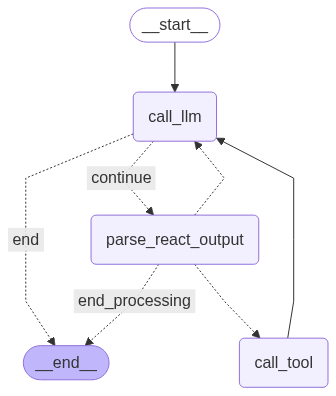

In [22]:
from IPython.display import display
import IPython.display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

IPython.display.display(
    IPython.display.Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [23]:
print(hf_questions[6]['question'])

Examine the video at https://www.youtube.com/watch?v=1htKBjuUWec.

What does Teal'c say in response to the question "Isn't that hot?"


In [24]:
stest = AgentState(question = "Which NBA teams are in the Eastern Conference Finals in 2025?")

In [25]:
# Setup states for questions and run agent
answers_payload = []
results_log = []
#for r in range(len(hf_questions)):
for r in [6]:
  s = AgentState(question = hf_questions[r]['question'],
              input_file = hf_questions[r]['input_file'],
              file_type = hf_questions[r]['file_type'],
              file_path = hf_questions[r]['file_path'])
  try:
      task_id = hf_questions[r]['task_id']
      question_text = hf_questions[r]['question']
      full_answer = run_agent(s)
      submitted_answer = extract_final_answer(full_answer[-1].content)
      answers_payload.append({"task_id": task_id, "model_answer": submitted_answer})
      results_log.append({"Task ID": task_id, "Question": question_text, "Submitted Answer": submitted_answer})
  except:
      print(f"Error running agent on task {task_id}: {e}")
      results_log.append({"Task ID": task_id, "Question": question_text, "Submitted Answer": f"AGENT ERROR: {e}"})

Loaded spaCy model: en_core_web_sm


<ipython-input-20-7c4d7d6ddf1e>:129: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self._embedding_model = HuggingFaceEmbeddings(model_name=self.embedding_model_name)
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device: cpu


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


BLIP VQA model loaded successfully
Running call_llm with memory management...
🧹 Pre-LLM CUDA cache cleared. Memory: 12823.1MB
Invoking LLM with 2 messages.


Formatted input for LLM:

[SYSTEM] You are a general AI assistant. with access to these tools:

    wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval - Fetches content from multiple Wikipedia pages based on intelligent NLP query processing of various search candidates, with strong prioritization of query entities. It then performs entity-focused semantic search across all fetched content to find the most relevant information, with improved retrieval for lists like discographies. Uses spaCy for named entity recognition and query enhancement. Input should be a search query or topic. Note: Uses the current live version of Wikipedia.
enhanced_search - Performs a DuckDuckGo web search and retrieves actual content from the top web results. Input should be a search query string. Returns search results with ex

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


LLM Response: [SYSTEM] You are a general AI assistant. with access to these tools:

    wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval - Fetches content from multiple Wikipedia pages based on intelligent NLP query processing of various search candidates, with strong prioritization ...
🧹 Post-LLM CUDA cache cleared. Memory: 12831.2MB
Running should_continue....
Running parse_react_output (First Action Input/FINAL ANSWER prioritized)...
Parsing content from after first '[ASSISTANT]' marker. Segment: 'Thought: I need to extract the transcript from the video to find the answer.
Action: youtube_transcr...'
ReAct: Found Action: youtube_transcript_extractor, Input: '{'youtube_url': 'https://www.youtube.com/watch?v=1htKBjuUWec'}' from effective_content: 'Thought: I need to extract the transcript from the video to find the answer.
Action: youtube_transcr...'
AIMessage updated with tool_calls: [{'name': 'youtube_transcript_extractor', 'args': {'youtube_url': 'http

In [26]:
print(submitted_answer)

FINAL ANSWER: it's not that hot, extremely


In [27]:

print(full_answer[-1].content)


[SYSTEM] You are a general AI assistant. with access to these tools:

    wikipedia_semantic_search_all_candidates_strong_entity_priority_list_retrieval - Fetches content from multiple Wikipedia pages based on intelligent NLP query processing of various search candidates, with strong prioritization of query entities. It then performs entity-focused semantic search across all fetched content to find the most relevant information, with improved retrieval for lists like discographies. Uses spaCy for named entity recognition and query enhancement. Input should be a search query or topic. Note: Uses the current live version of Wikipedia.
enhanced_search - Performs a DuckDuckGo web search and retrieves actual content from the top web results. Input should be a search query string. Returns search results with extracted content from web pages, making it much more useful for answering questions. Use this tool when you need up-to-date information, details about current events, or when other tool